1. [The goal](#1)
1. [Data Exploration](#2)
1. [Data preprocessing](#3)
    - Fill missing values

1. [Features engineering](#7)
    - Encoding our categorical variables
    - Create training and test set
1. [Modeling](#4)
    - Linear Regression
    - All models
    - Ridge
    - XGBoost
    - GradientBoostingRegressor
1. [Function to wrap up](#5)
1. [Setup our next models](#6)
    - Blending and stacking
    - Models with less variable

<a id="1"></a> <br>
## The Goal
- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.
- Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by our model, and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect our score equally.

In [59]:
#https://anaconda.org/conda-forge/mlxtend
#conda install -c conda-forge mlxtend

In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, LassoCV, RidgeCV ,ElasticNetCV, PassiveAggressiveRegressor, HuberRegressor, TheilSenRegressor

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

from mlxtend.regressor import StackingCVRegressor

import missingno as msno

In [280]:
#Let's import our data

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [12]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [13]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

<a id="2"></a> <br>
## Data Exploration

Let's first see which type of features we have here :

In [81]:
train.select_dtypes(exclude = 'object').columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [80]:
train.select_dtypes(include = 'object').columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

We have 37 numerical features and 43 categorical features.

In [63]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


Shape of your Data Set: (1460, 81)
Classifying variables in data set...
    80 Predictors classified...
        This does not include the Target column(s)
    4 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 6
Could not draw Distribution Plots
Could not draw Time Series plots
Number of Cat and Continuous Vars exceeds 30, hence no Pivot Tables
Time to run AutoViz (in seconds) = 1.307


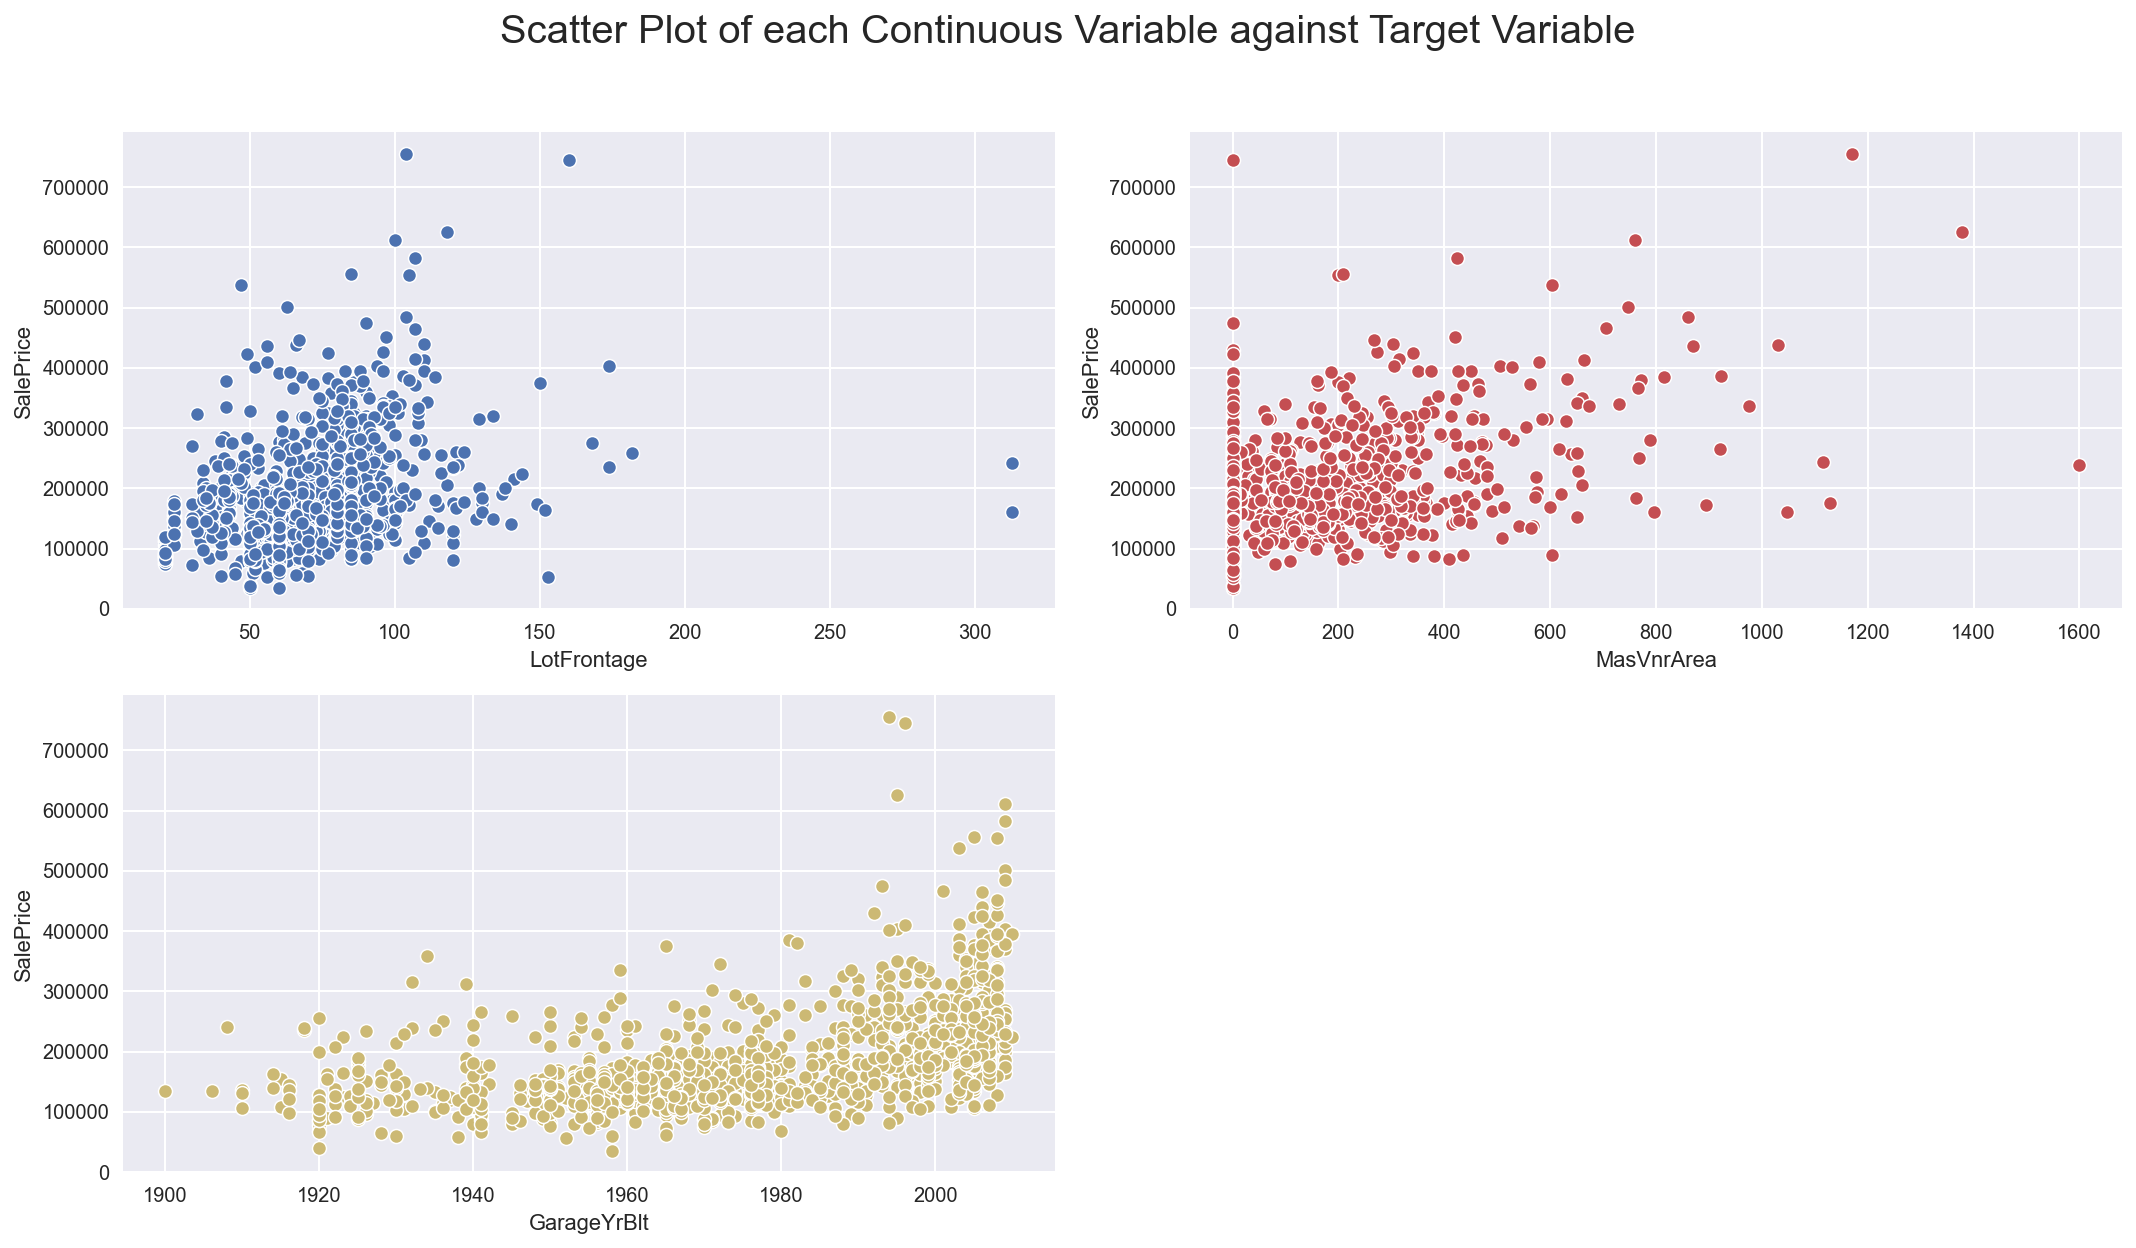

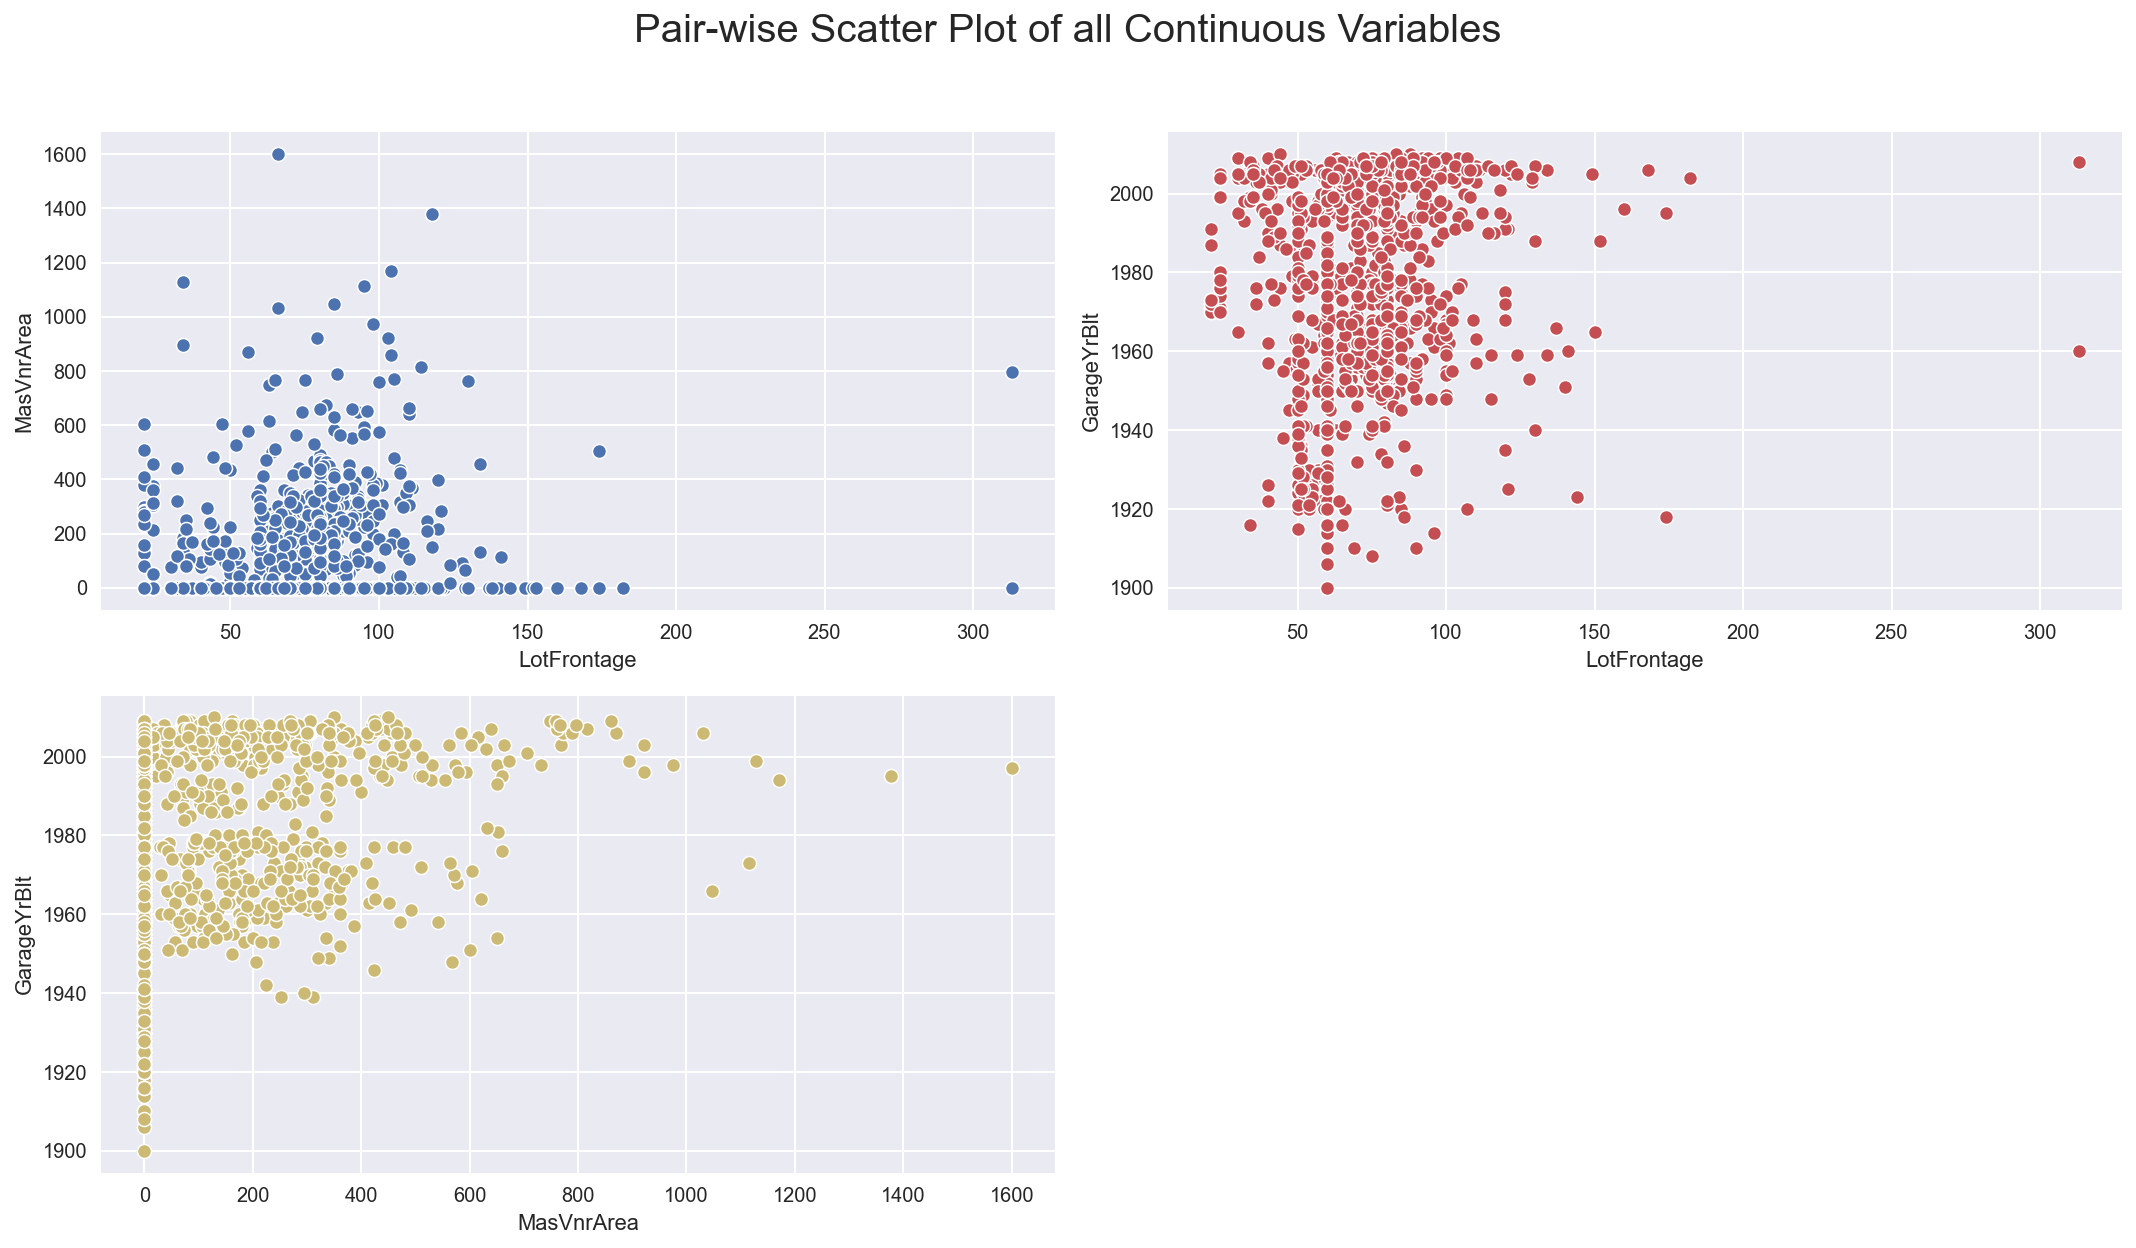

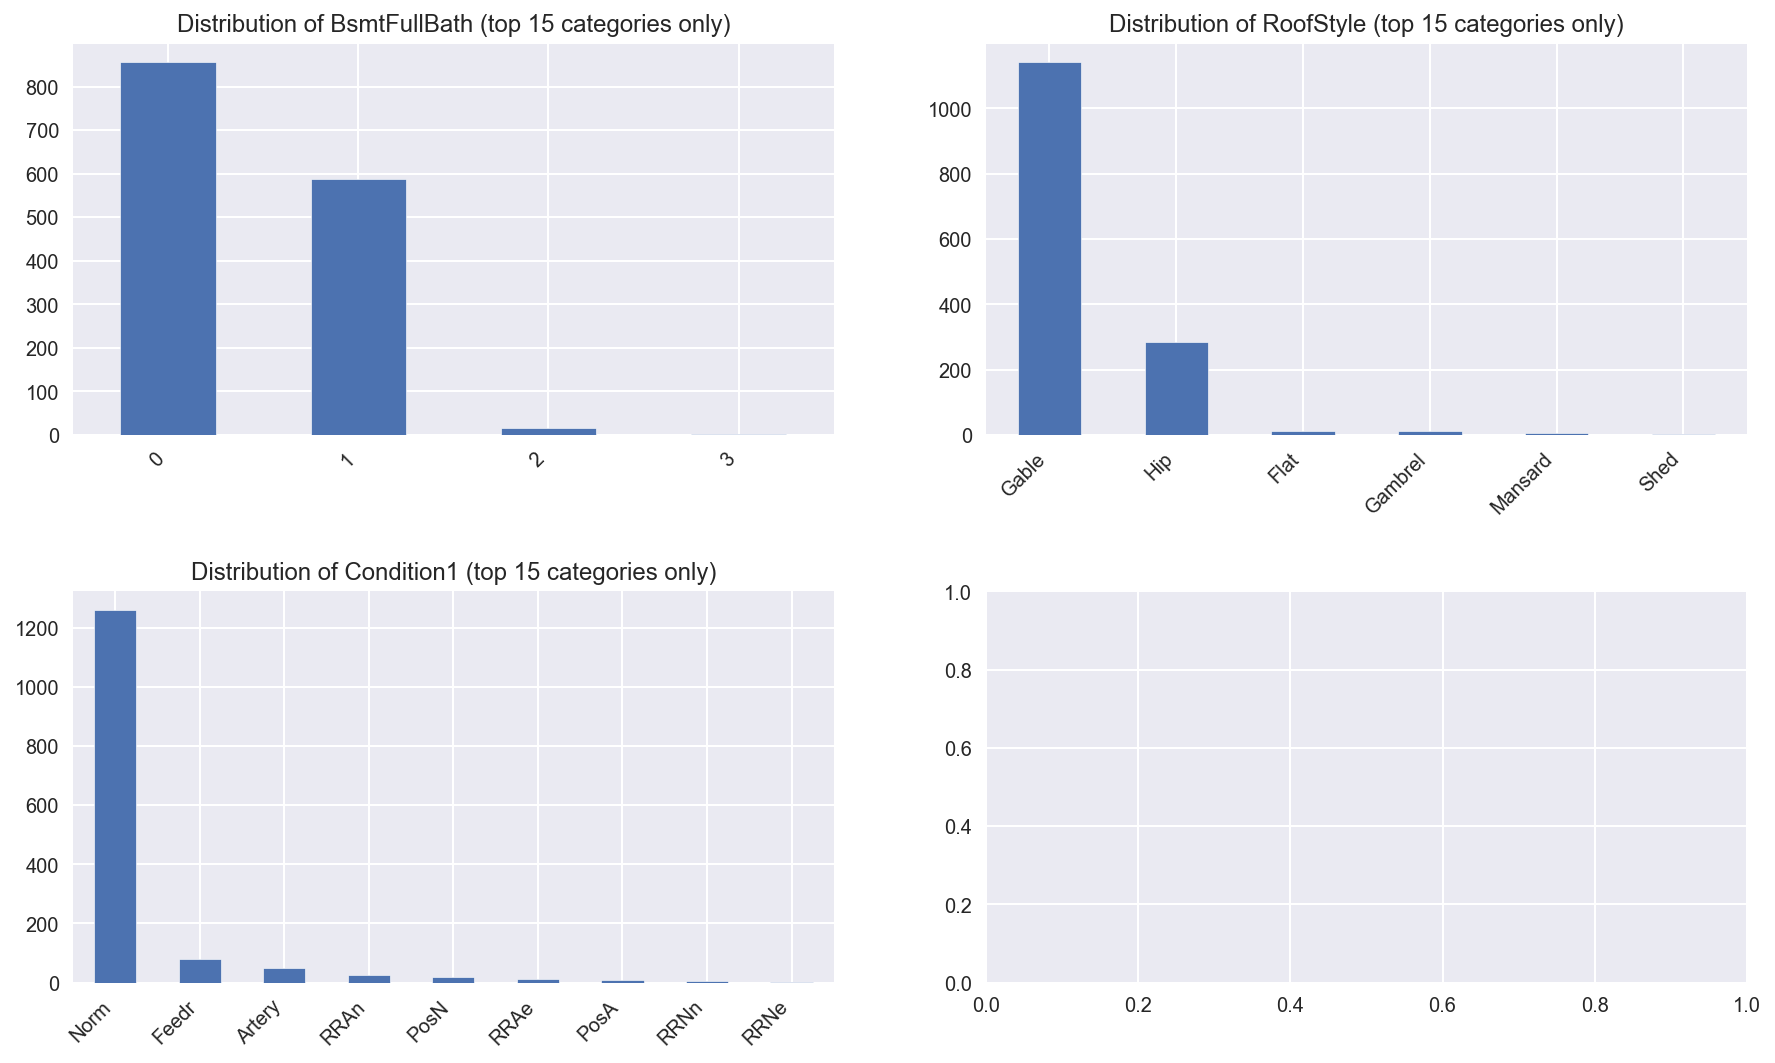

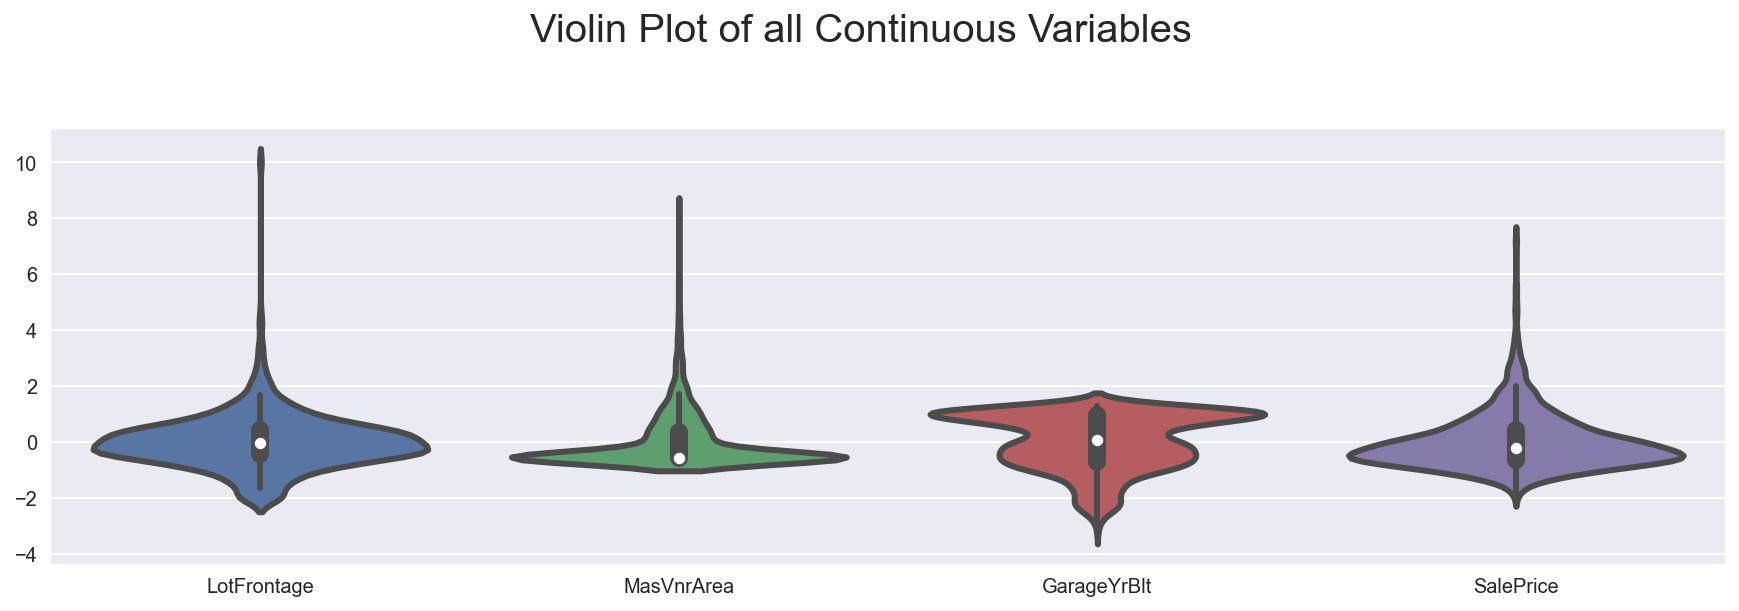

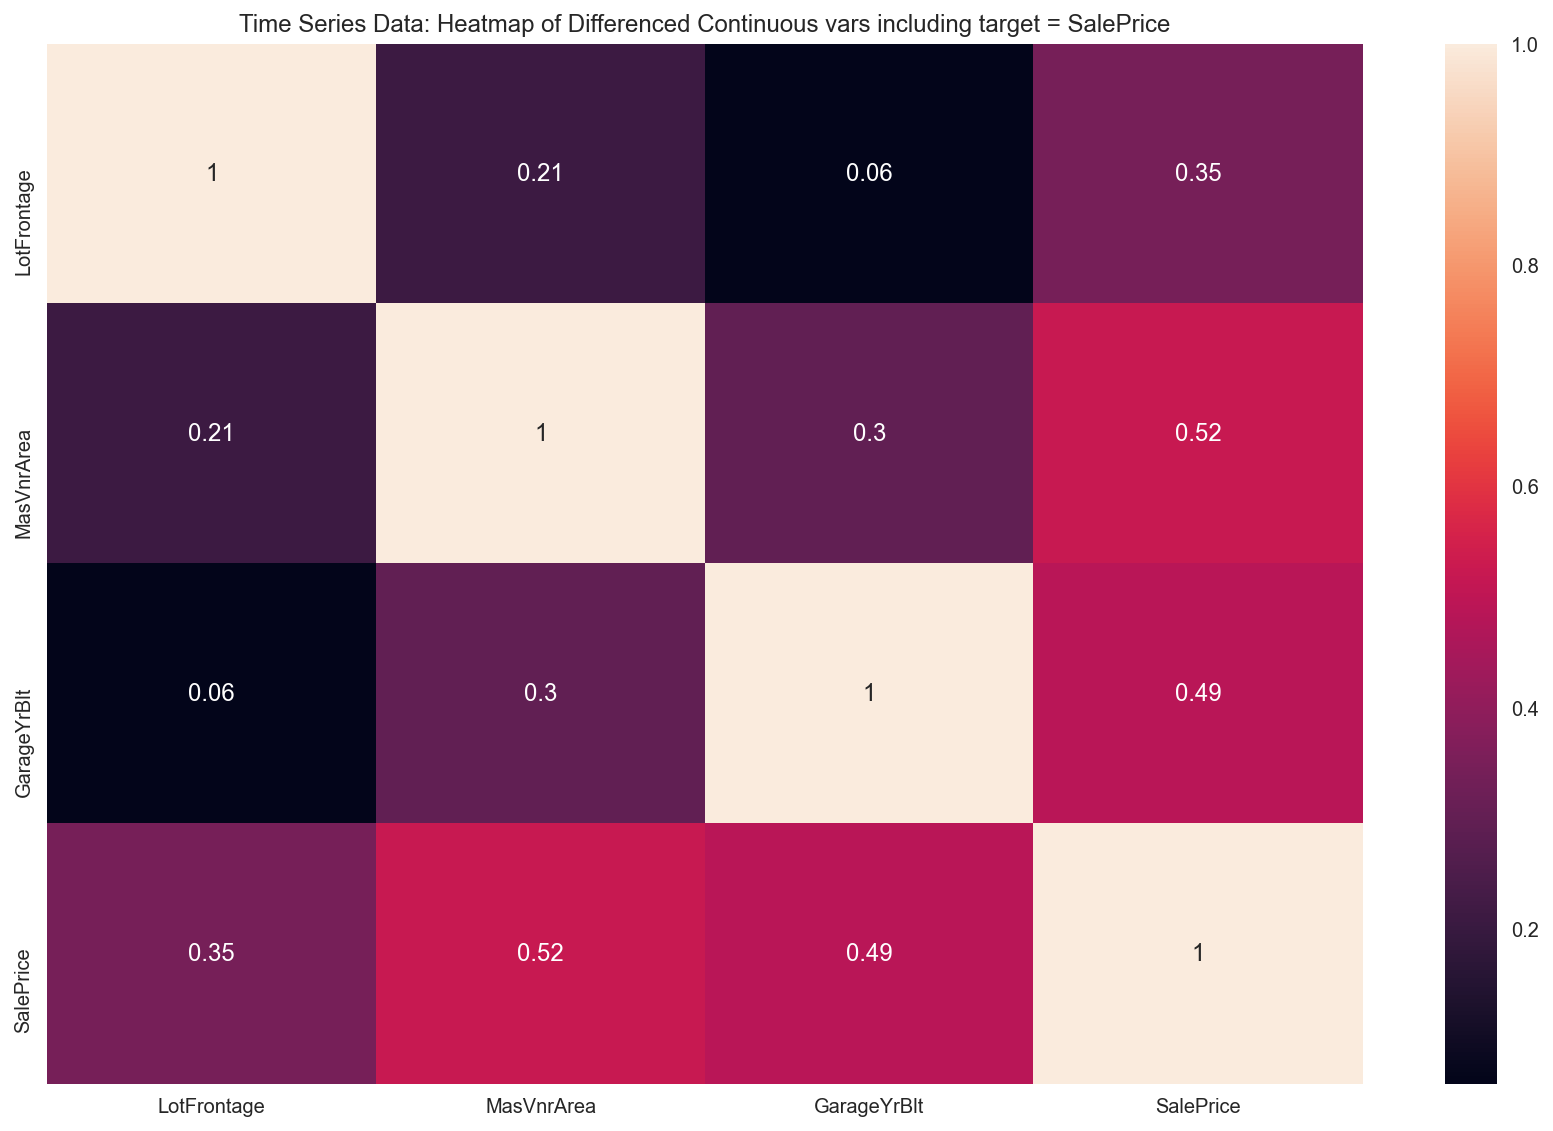

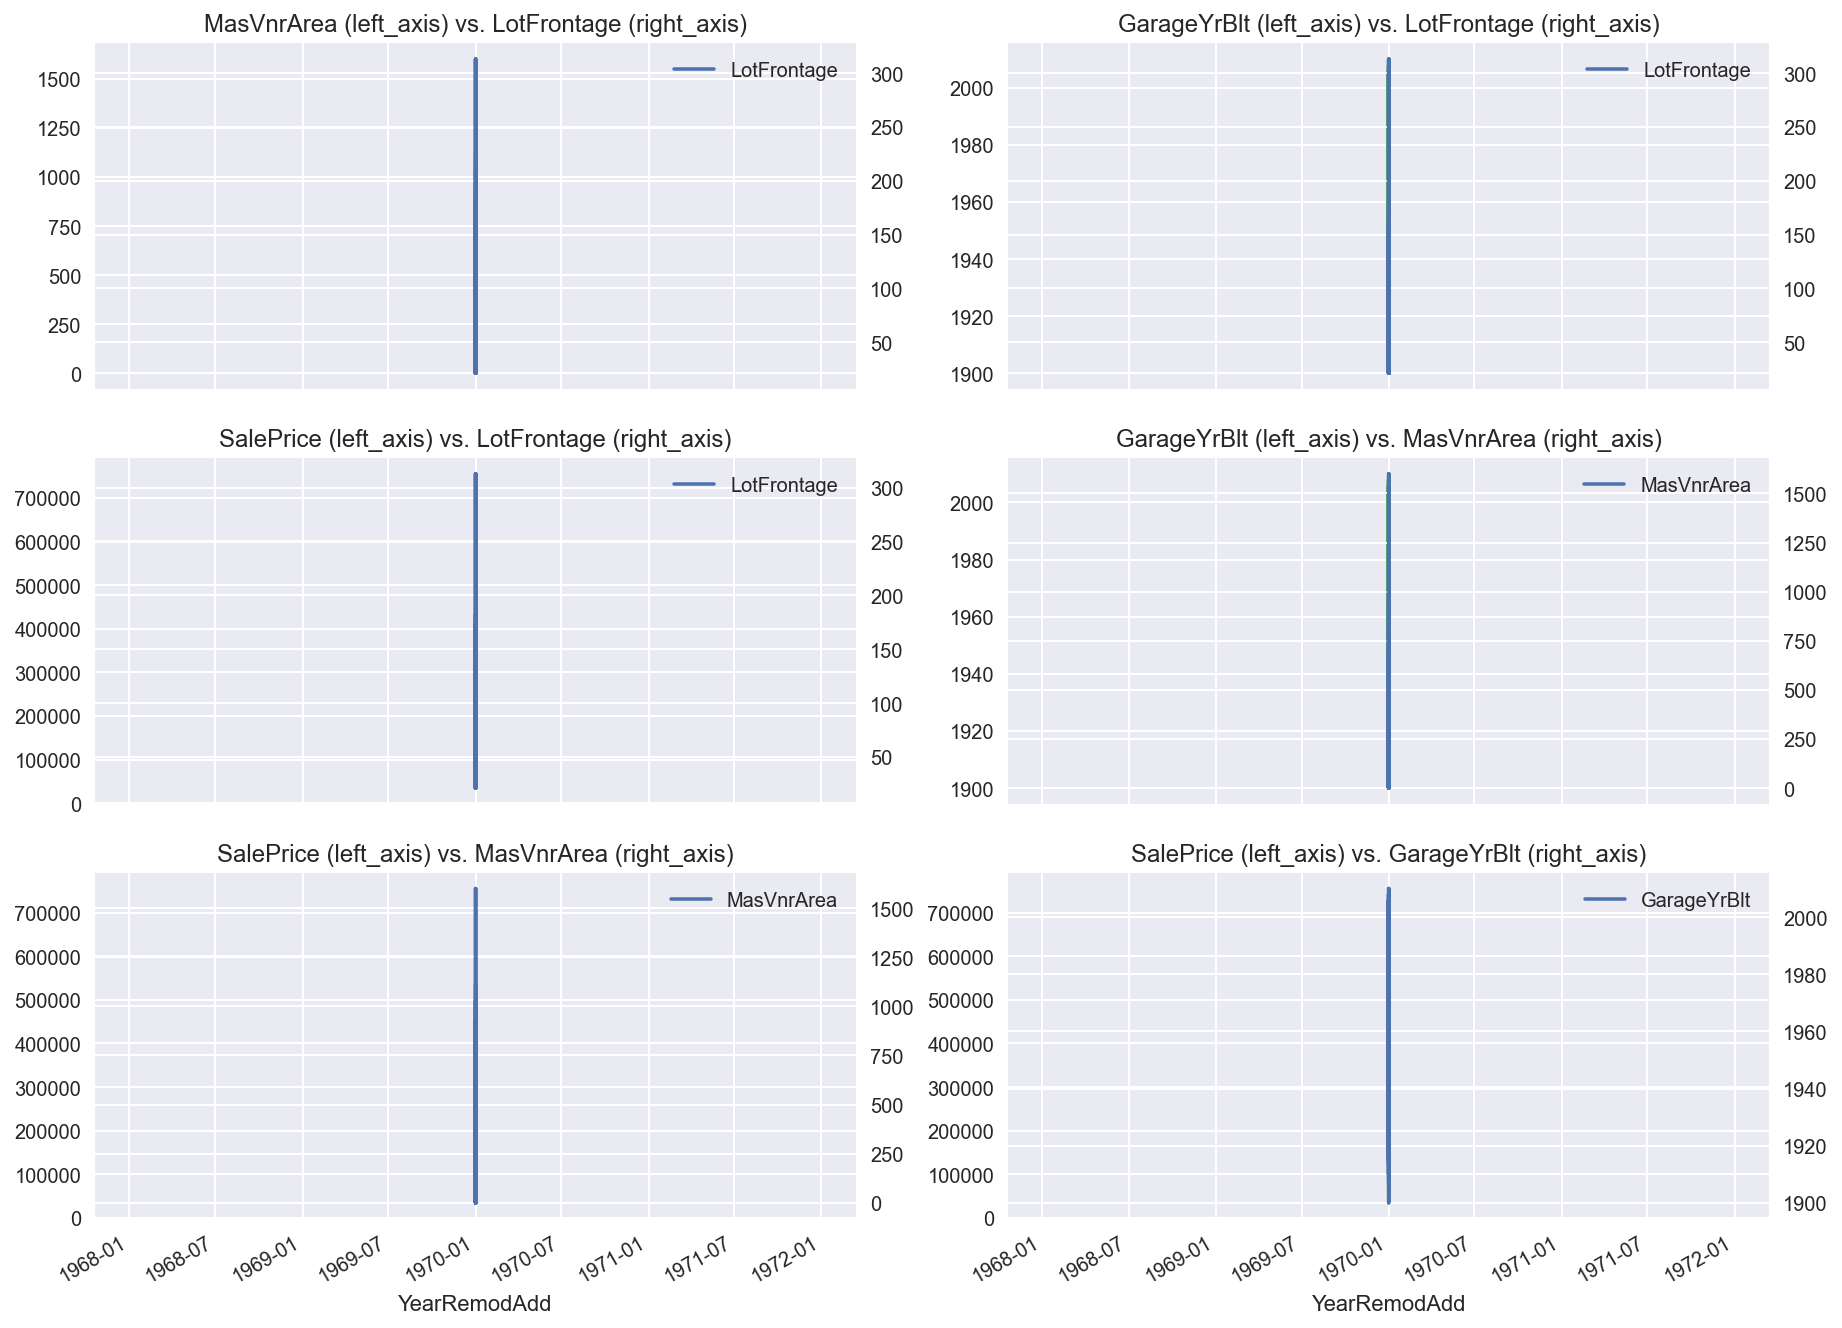

In [71]:
sep = '\,'
target = 'SalePrice'
datapath = ''
filename = 'train.csv'

dft = AV.AutoViz(datapath+filename, sep = sep,  depVar=target, dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg')

Let's find the highly-correlated (correlations higher than 0.8)

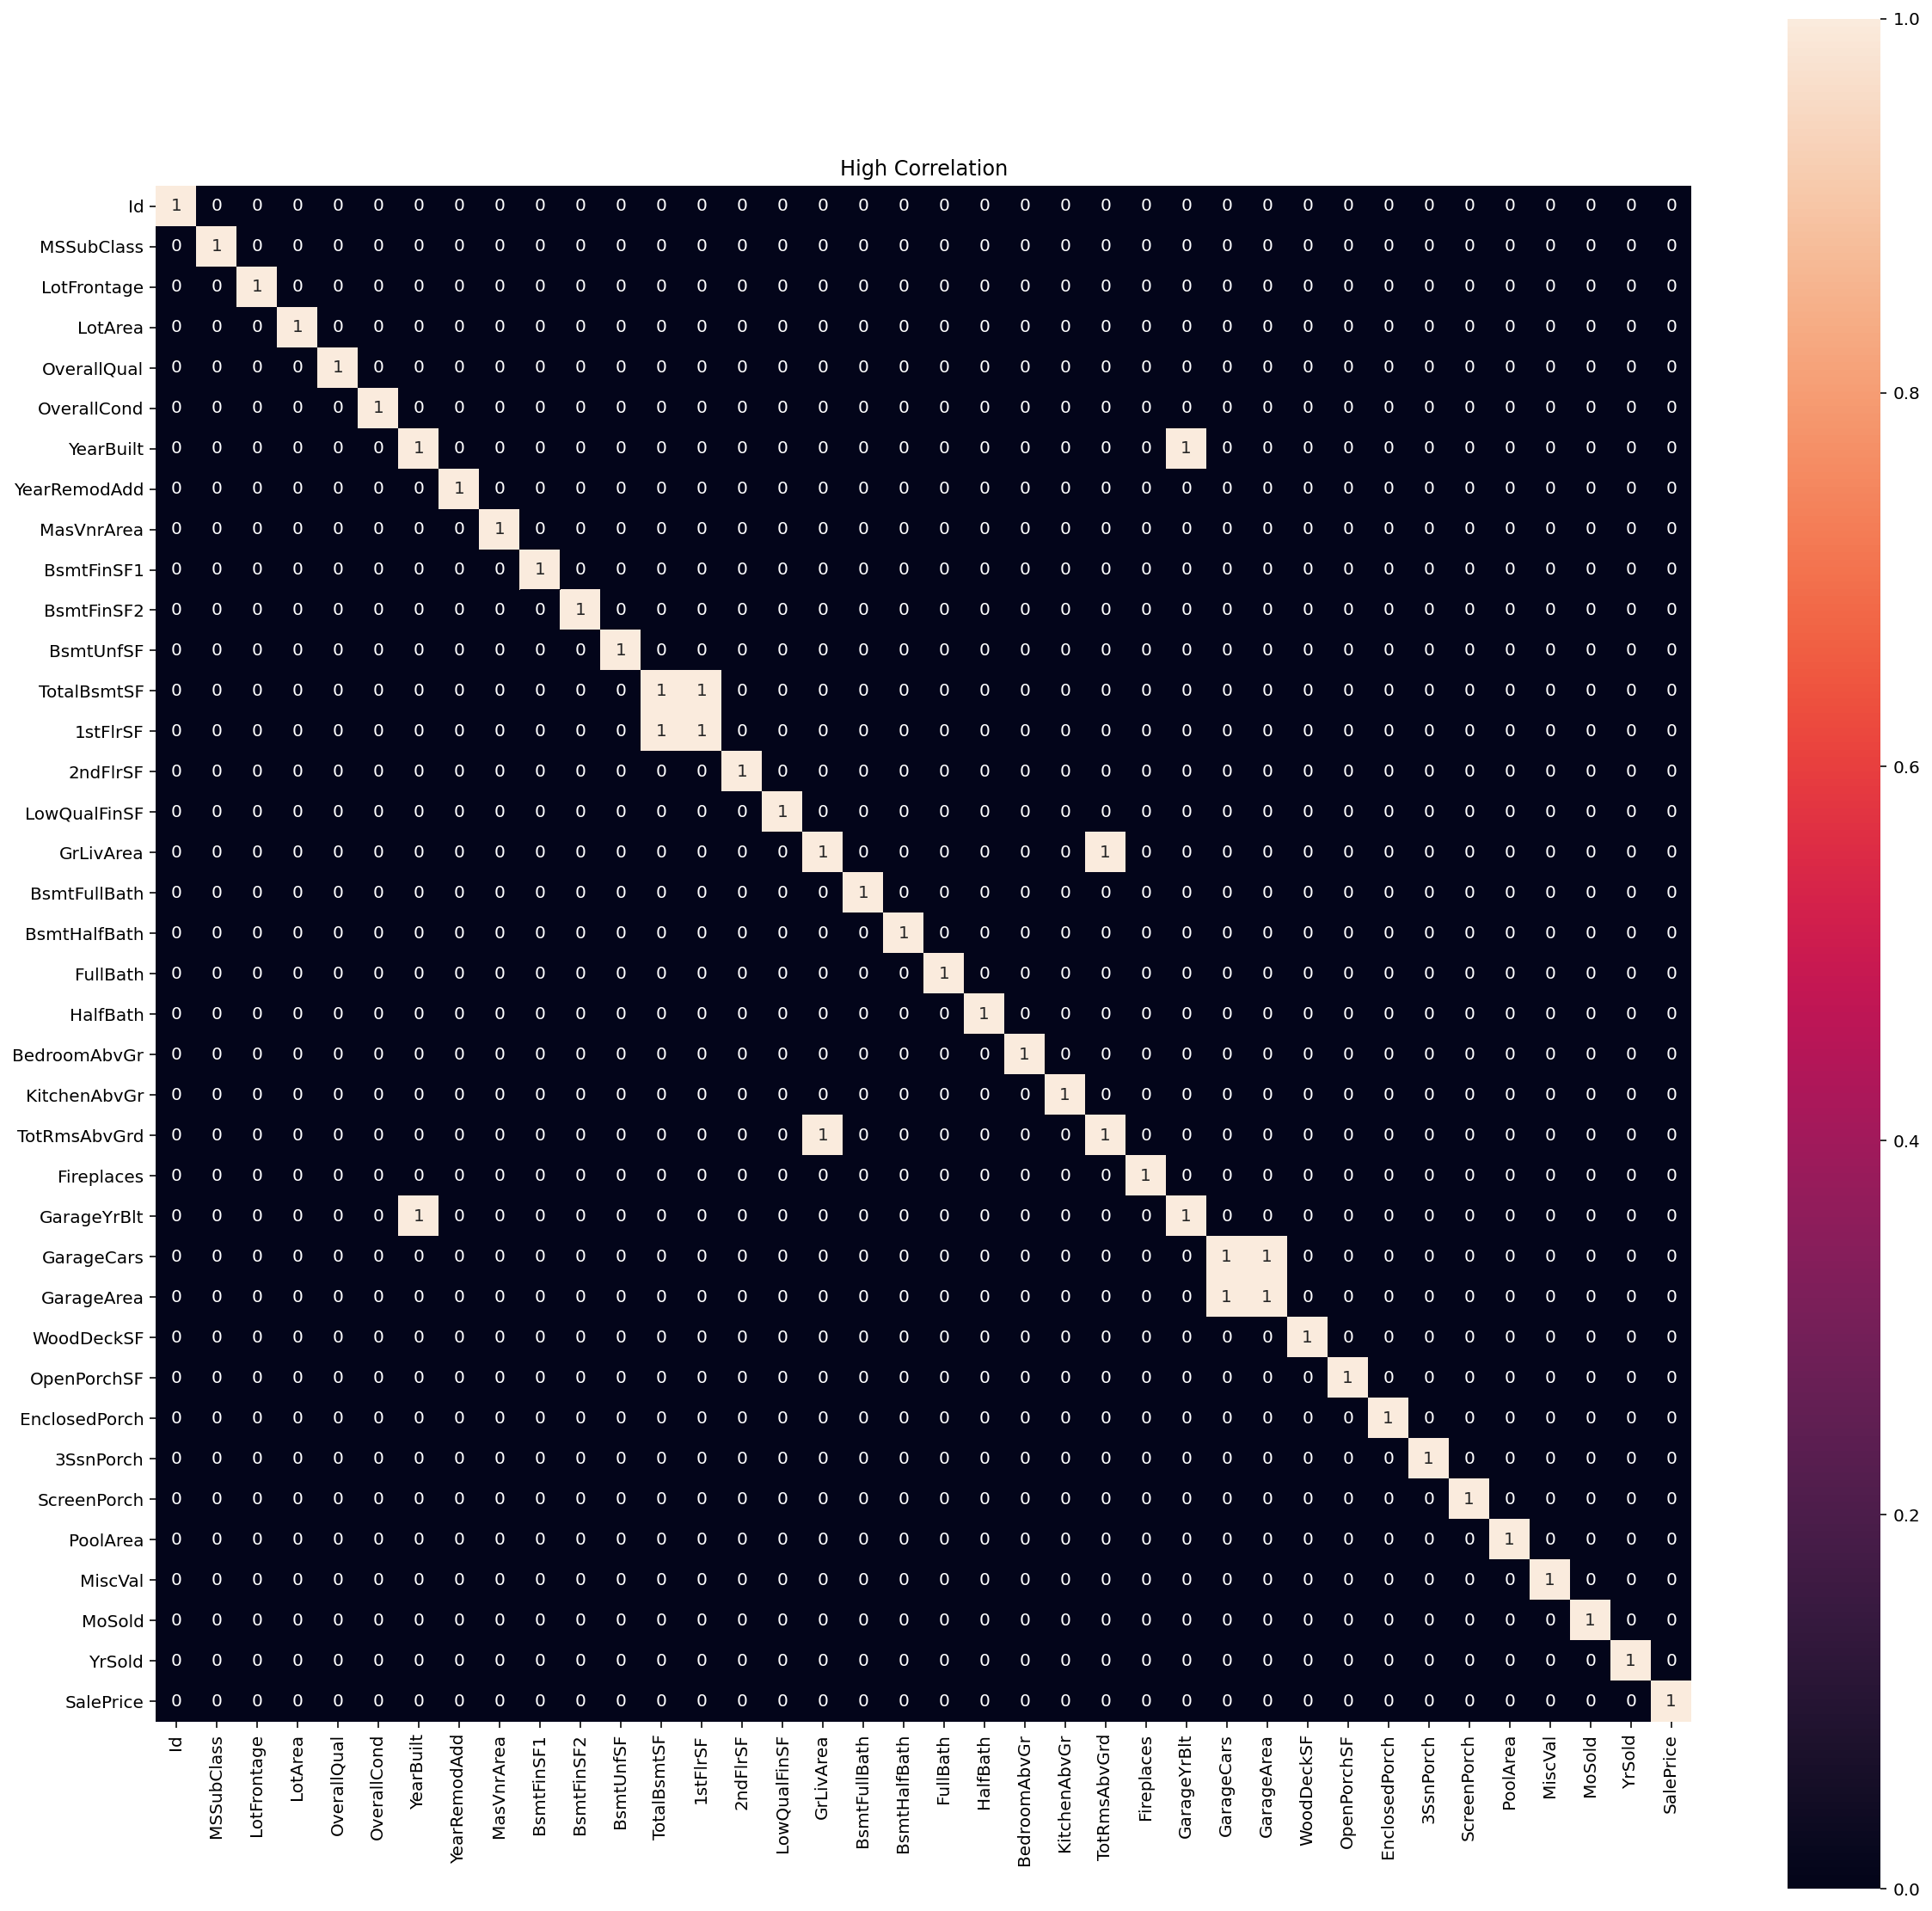

In [5]:
num_correlation = train.select_dtypes(exclude='object').corr()
plt.figure(figsize=(20,20))
plt.title('High Correlation')
sns.heatmap(num_correlation > 0.8, annot=True, square=True);

Highly-Correlated Features:

- YearBuilt vs GarageYrBlt
- 1stFlrSF vs TotalBsmtSF
- GrLivArea vs TotRmsAbvGrd
- GarageCars vs GarageArea

In [6]:
corr = num_correlation.corr()
print(corr['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.962500
GarageCars       0.903554
GarageArea       0.900257
TotalBsmtSF      0.817396
GrLivArea        0.814702
FullBath         0.811329
MasVnrArea       0.807608
1stFlrSF         0.797333
YearBuilt        0.785608
YearRemodAdd     0.762841
GarageYrBlt      0.756271
Fireplaces       0.731032
TotRmsAbvGrd     0.638194
OpenPorchSF      0.607920
LotFrontage      0.596063
WoodDeckSF       0.581711
BsmtFinSF1       0.515448
BsmtUnfSF        0.436888
HalfBath         0.406281
LotArea          0.384865
2ndFlrSF         0.288677
BsmtFullBath     0.288590
BedroomAbvGr     0.193856
PoolArea         0.046162
ScreenPorch      0.034179
MoSold          -0.022081
3SsnPorch       -0.032712
Id              -0.192466
YrSold          -0.207811
BsmtFinSF2      -0.215899
BsmtHalfBath    -0.234746
LowQualFinSF    -0.252426
MiscVal         -0.262012
MSSubClass      -0.263538
KitchenAbvGr    -0.362060
OverallCond     -0.471958
EnclosedPorch   -0.477651
Name: SalePr

In [7]:
corr[corr['SalePrice']>0.3].index

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'SalePrice'],
      dtype='object')

We can see the most correlated variable to the target SalePrice.

In [281]:
train.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True) 
test.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True)

In [282]:
# Useless Columns...
train=train.drop(columns=['Street','Utilities']) 
test=test.drop(columns=['Street','Utilities']) 

Let's plot how SalePrice relates to some of the features in the dataset

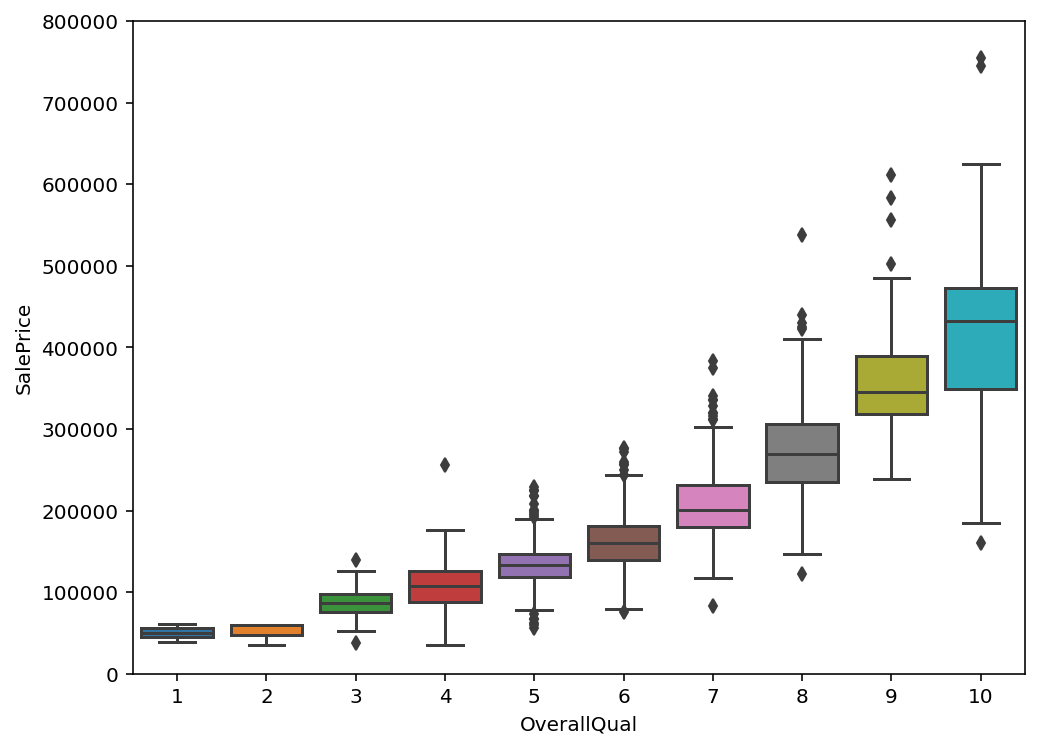

In [72]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

That's seems quite correlated !

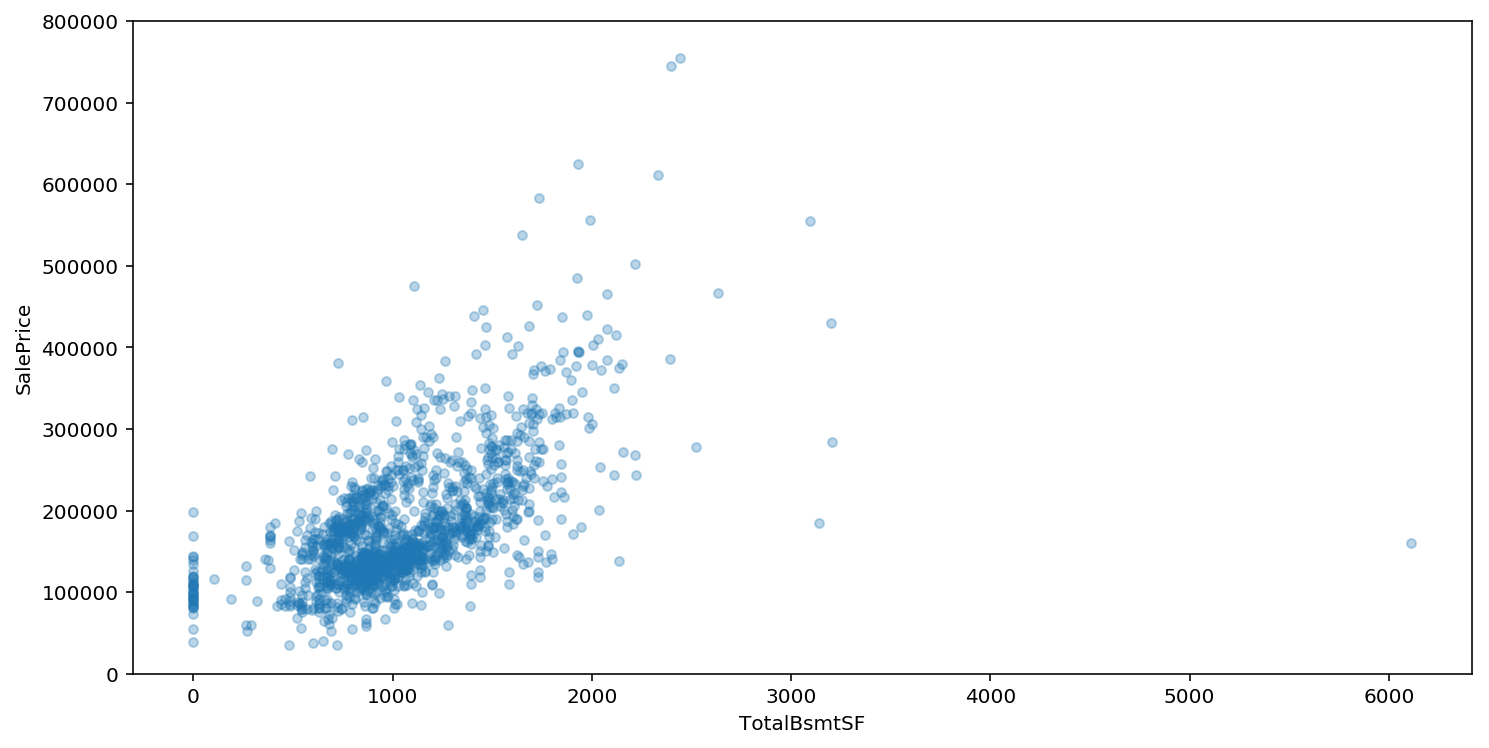

In [73]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

It seems to have a little tendance

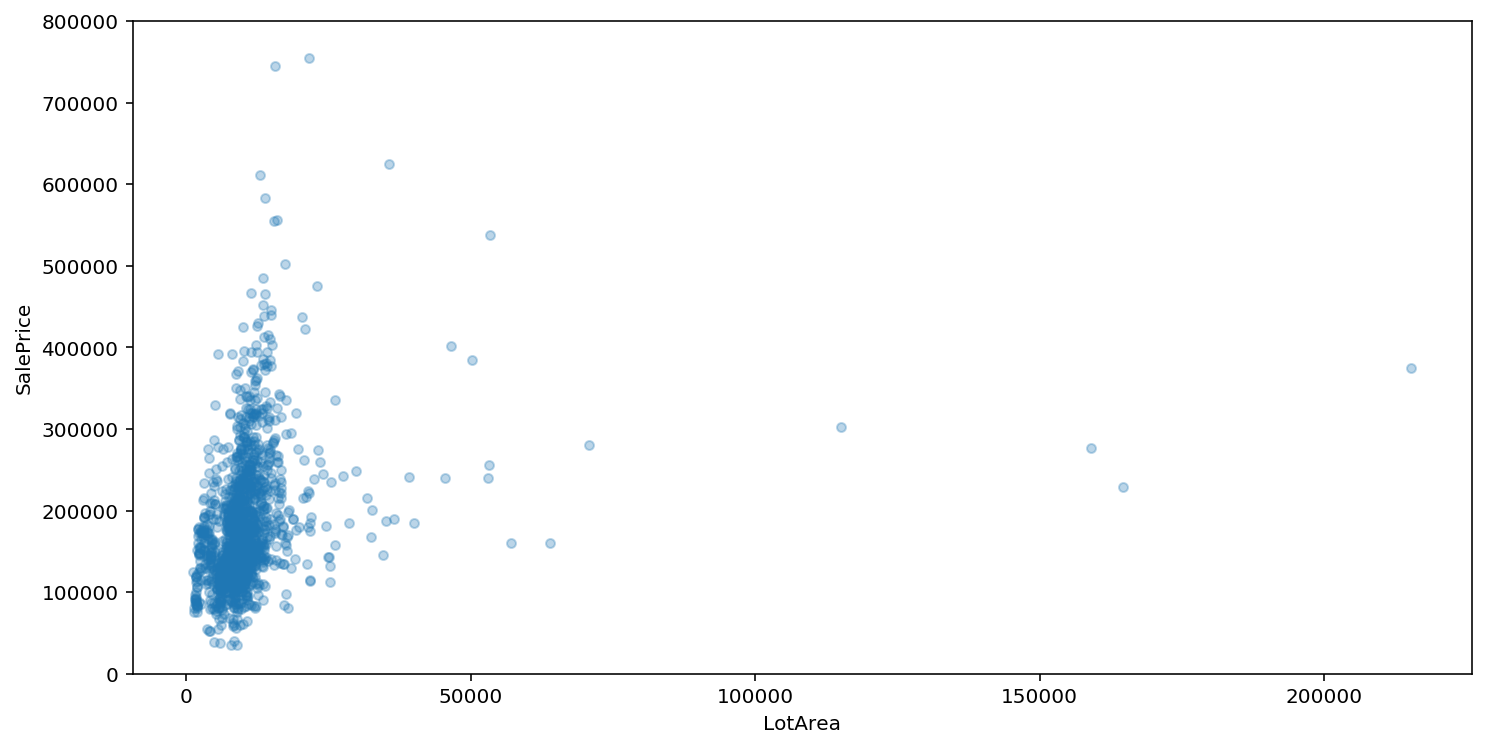

In [75]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

Here, these two variables doesn't seems related.

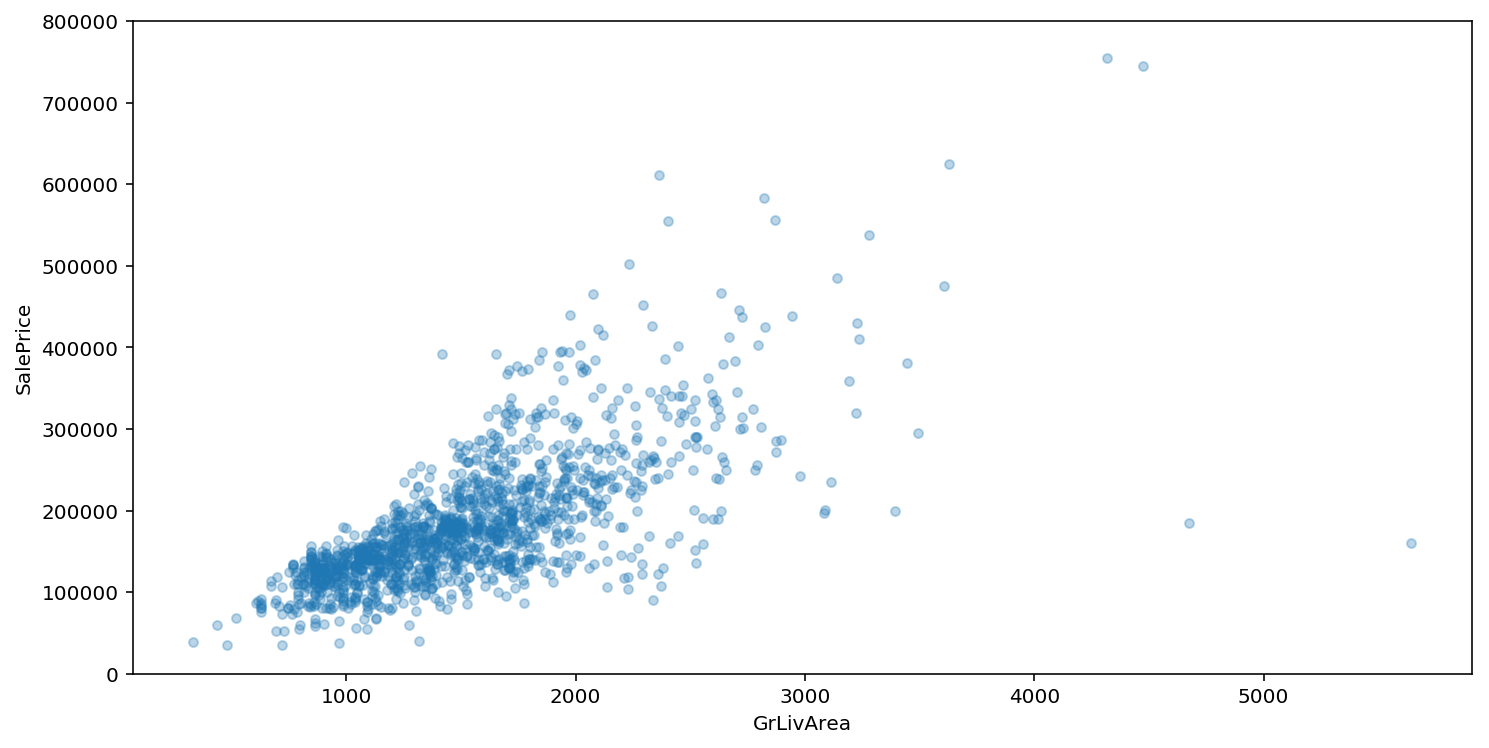

In [76]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

These two variable seems highly related !

<a id="3"></a> <br>
## Data preprocessing: 

Preprocessing is a crucial step in Data Science. You can make the most optimal model with the most optimal hyperparamter, if you haven't process in a right way your data, you will rarely get anything at all. So let's do this properly.

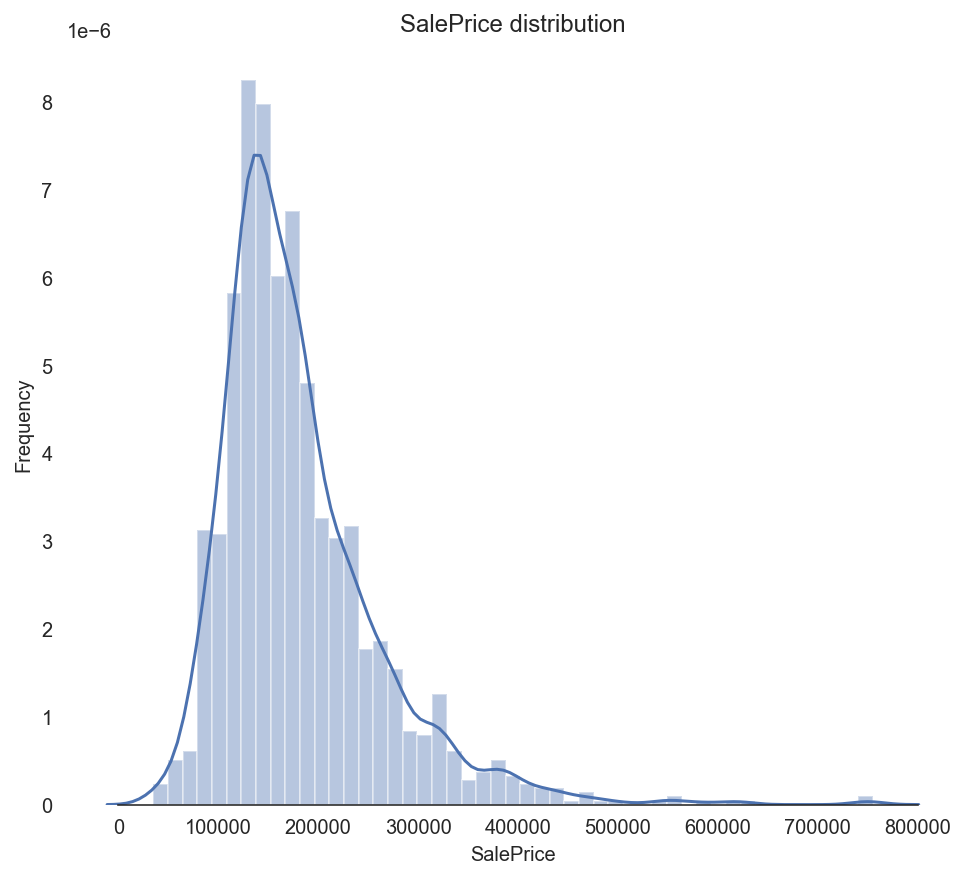

In [15]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.

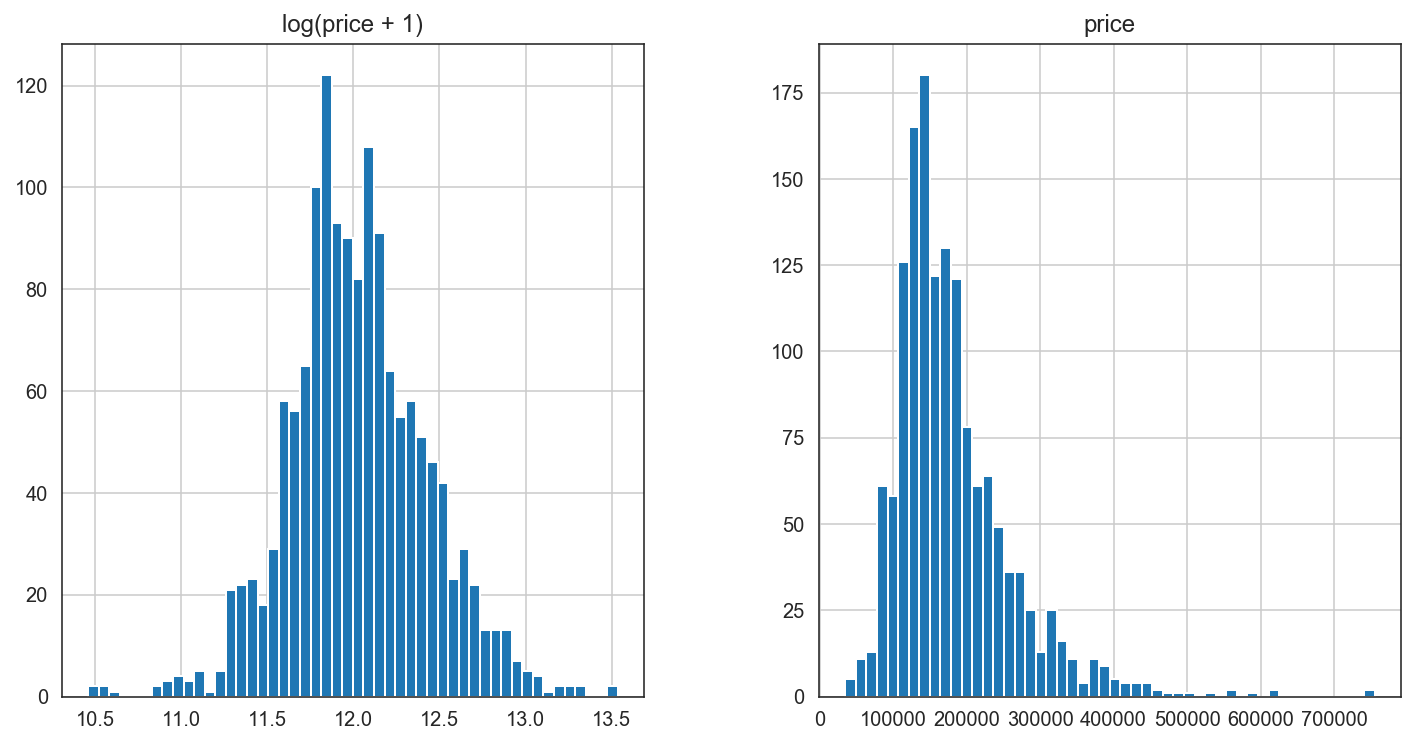

In [84]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist(bins = 50);

That's look better right ? The SalePrice is now normally distributed, great !

In [283]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [284]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

**Fill missing values**

Let's check the variable with the most missing values

In [285]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [279]:
((all_data.isnull().sum().sort_values(ascending = False)/len(all_data))*100).head(30)

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageQual       5.450806
GarageCond       5.450806
GarageFinish     5.450806
GarageType       5.382242
BsmtCond         2.811107
BsmtExposure     2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
Functional       0.068564
BsmtHalfBath     0.068564
BsmtFullBath     0.068564
Electrical       0.034282
GarageCars       0.034282
BsmtFinSF1       0.034282
Exterior2nd      0.034282
BsmtFinSF2       0.034282
KitchenQual      0.034282
BsmtUnfSF        0.034282
TotalBsmtSF      0.034282
SaleType         0.034282
dtype: float64

At first glance, it appears that we will have a lot of work to deal with missing values.

But don't worry, after reading carrefully the data_description.txt file attached, most of the missing values correponds to None values, they aren't missing value.

For most of these missing values, it appears that the NA correspond to the absence of the feature, so actually it is an information (for example , a house that doesn't have an Alley access, a Pool or a Fence ...).

Except for some features (LotFrontage espacially), all we need is to rename the NA category to 'None' or 'No' (in my case).

In [286]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    features['GarageCars'] = features['GarageCars'].fillna(0)
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")

    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_data = handle_missing(all_data)

Let's make sure we handled all the missing values

In [287]:
all_data.isnull().sum().sort_values(ascending = False).head(5)

SaleCondition    0
TotalBsmtSF      0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

That's seems good !

<a id="7"></a> <br>
## Features engineering

Like preprocessing, this is a crucial step.

Feature Engineering is one of the most important steps to complete before starting a Machine Learning analysis.Most of the basic Feature Engineering techniques consist of finding inconsistencies in the data and of creating new features by combining/diving existing ones. Creating the best possible Machine Learning/Deep Learning model can certainly help to achieve good results, but choosing the right features in the right format to feed in a model can by far boost performances

**Numerical values/ Reduce skewness**

In [288]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index


skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [289]:
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

Skewed features: MSSubClass


---------- 



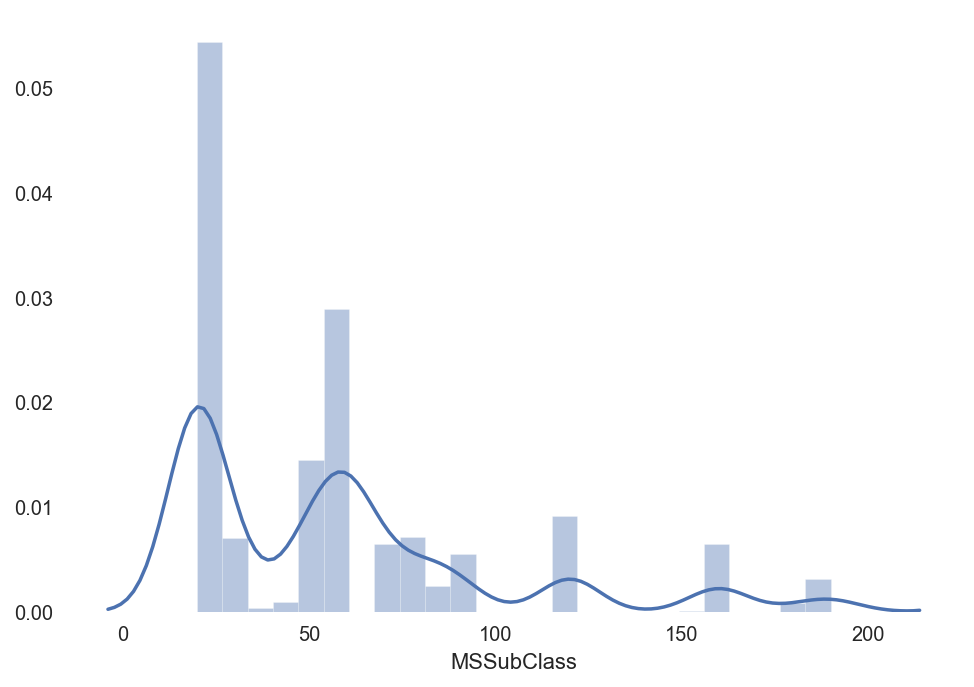

---------- 

Skewed features: LotFrontage


---------- 



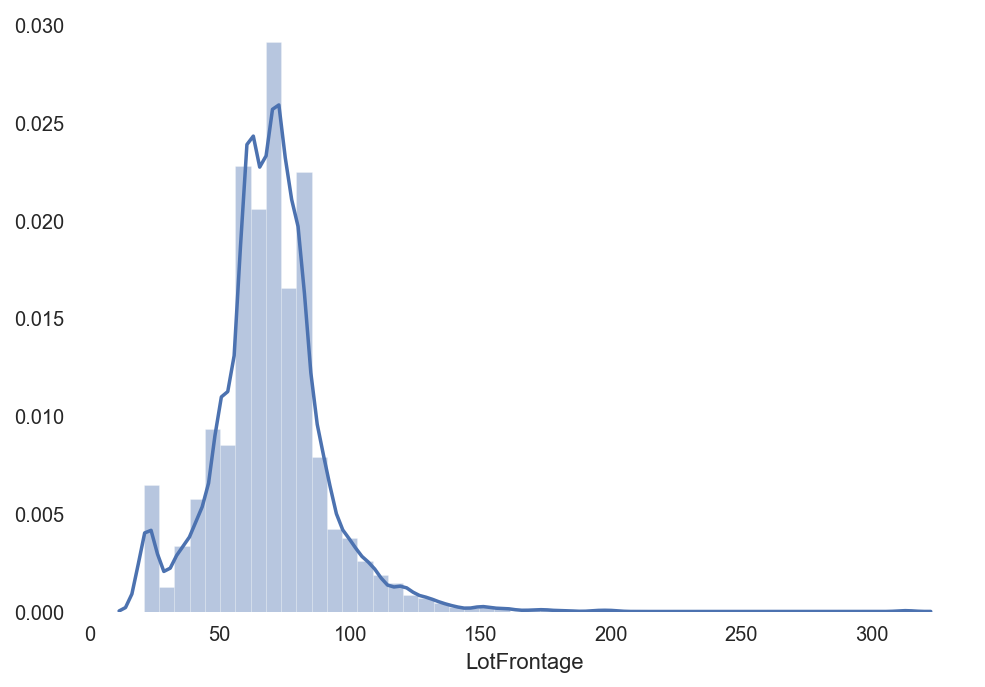

---------- 

Skewed features: LotArea


---------- 



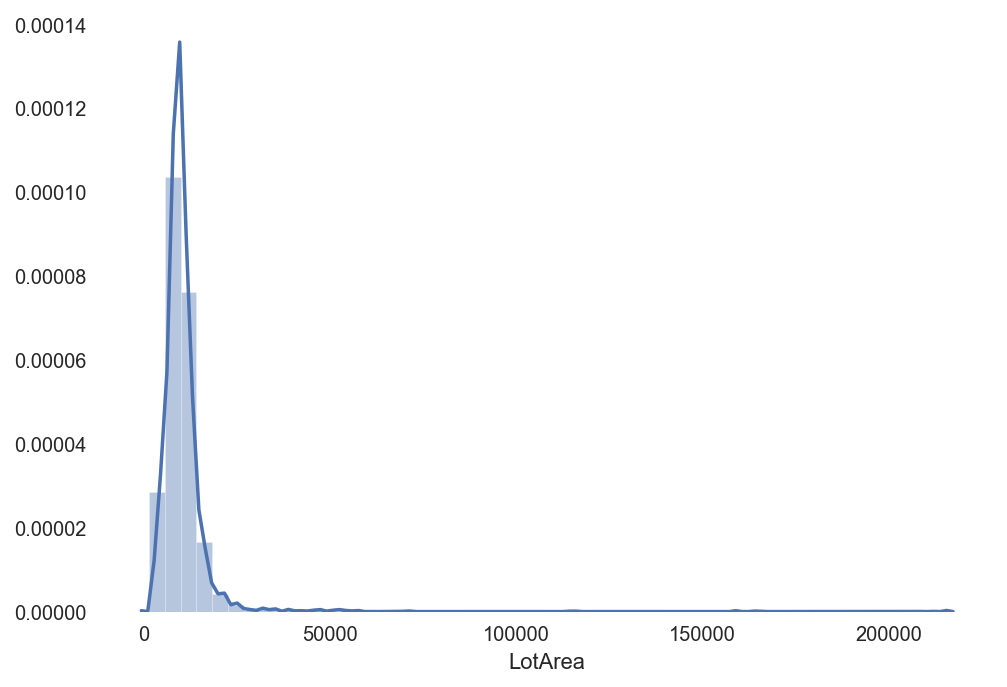

---------- 

Skewed features: MasVnrArea


---------- 



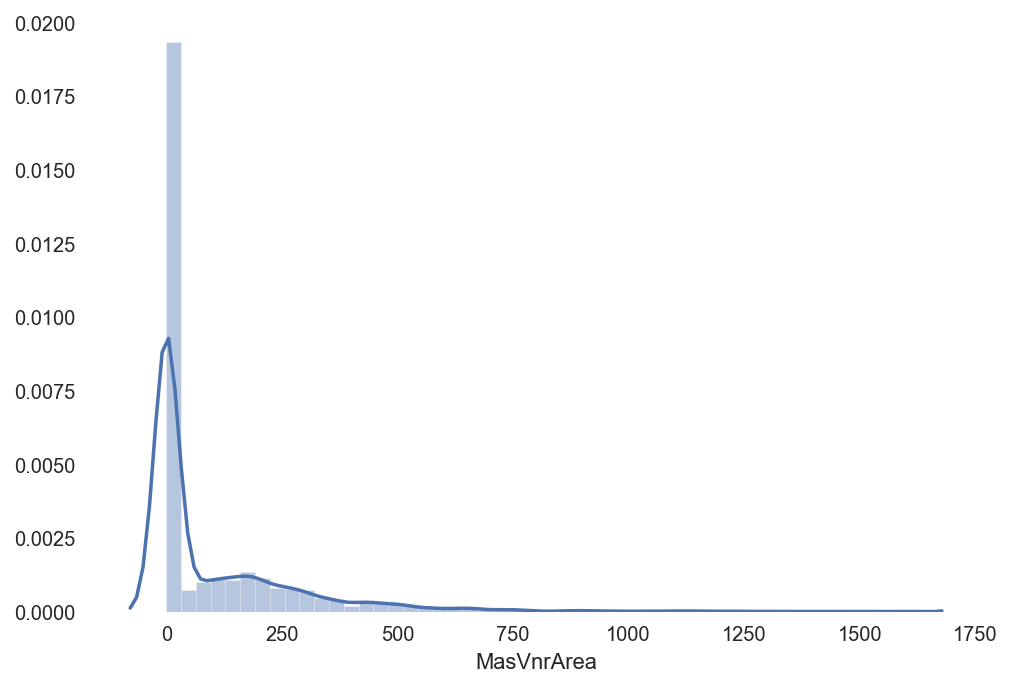

---------- 

Skewed features: BsmtFinSF1


---------- 



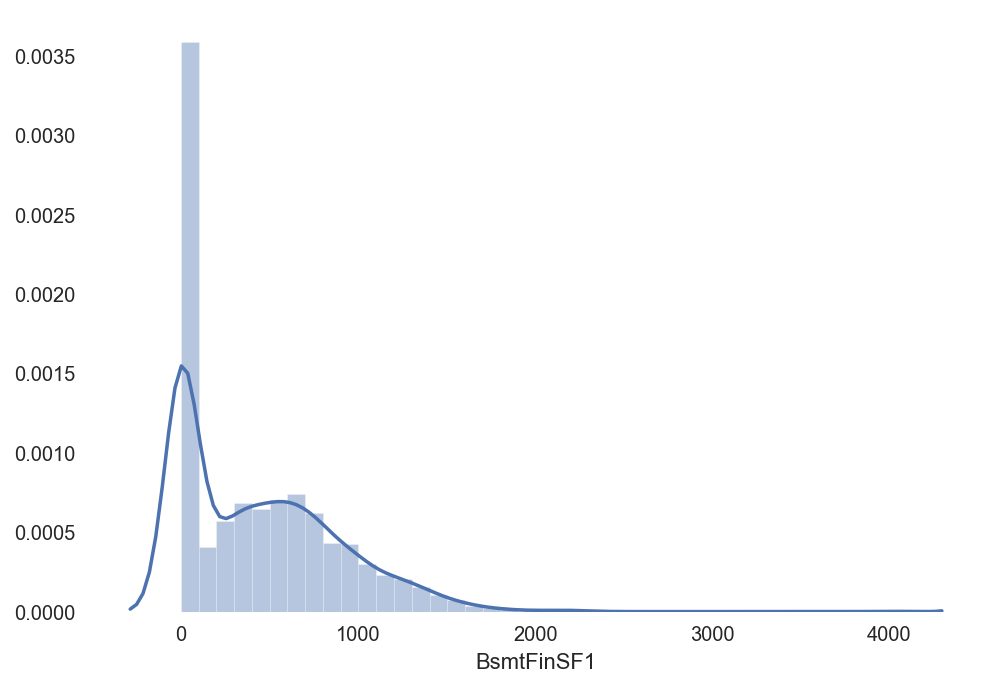

---------- 

Skewed features: BsmtUnfSF


---------- 



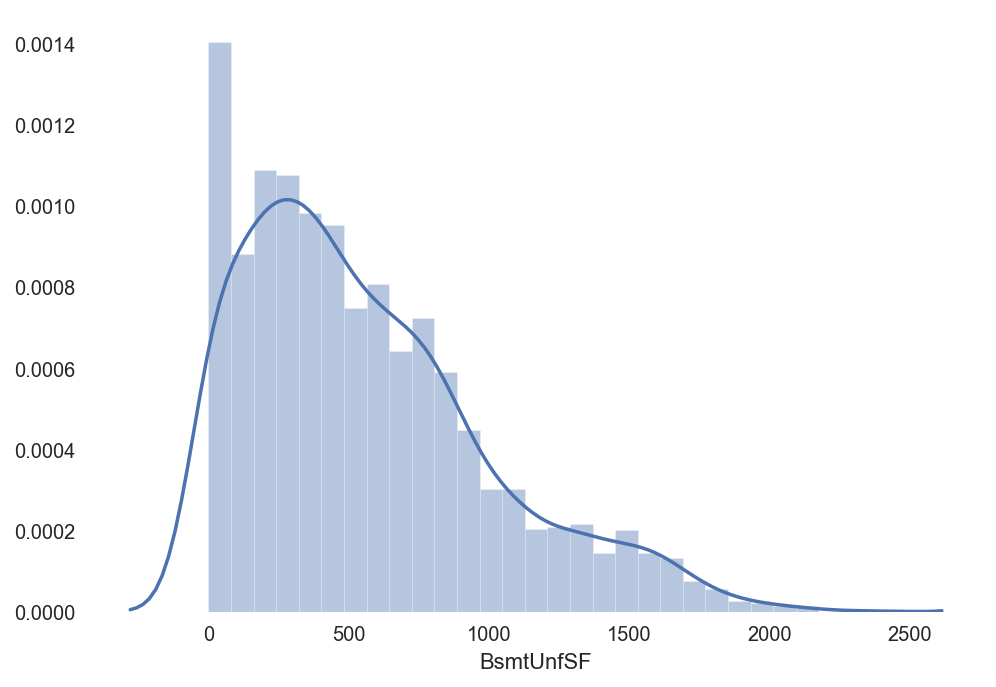

---------- 

Skewed features: 2ndFlrSF


---------- 



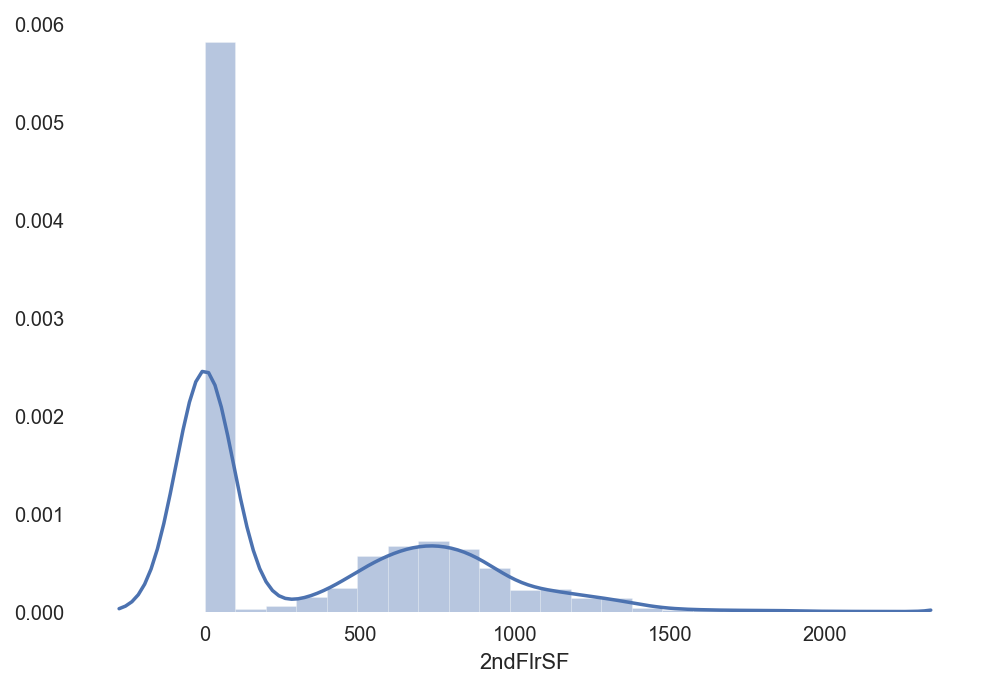

---------- 

Skewed features: GrLivArea


---------- 



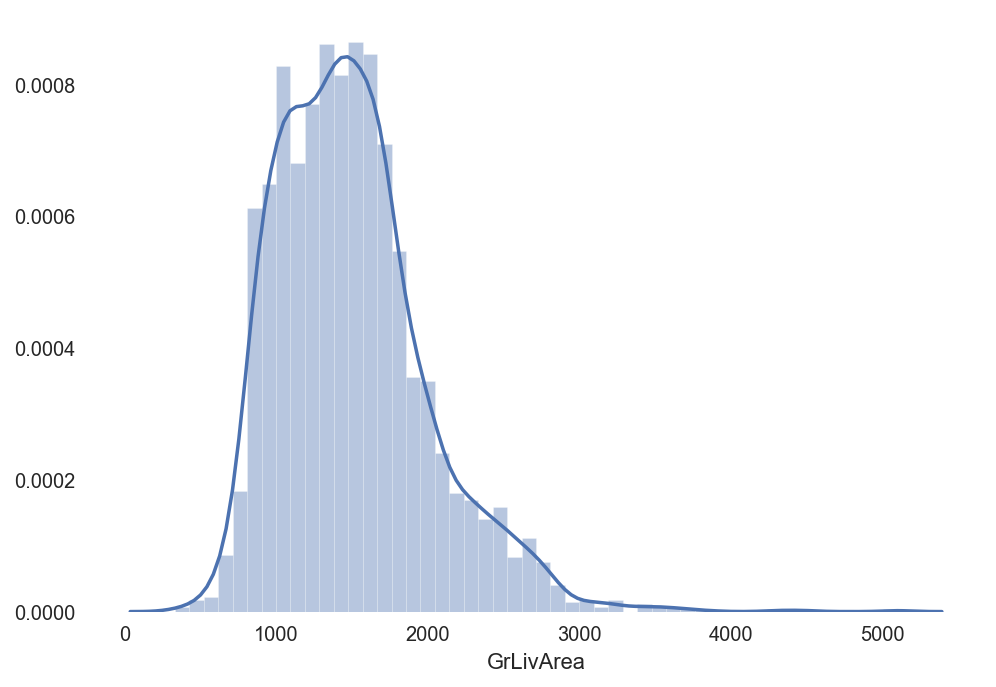

---------- 

Skewed features: WoodDeckSF


---------- 



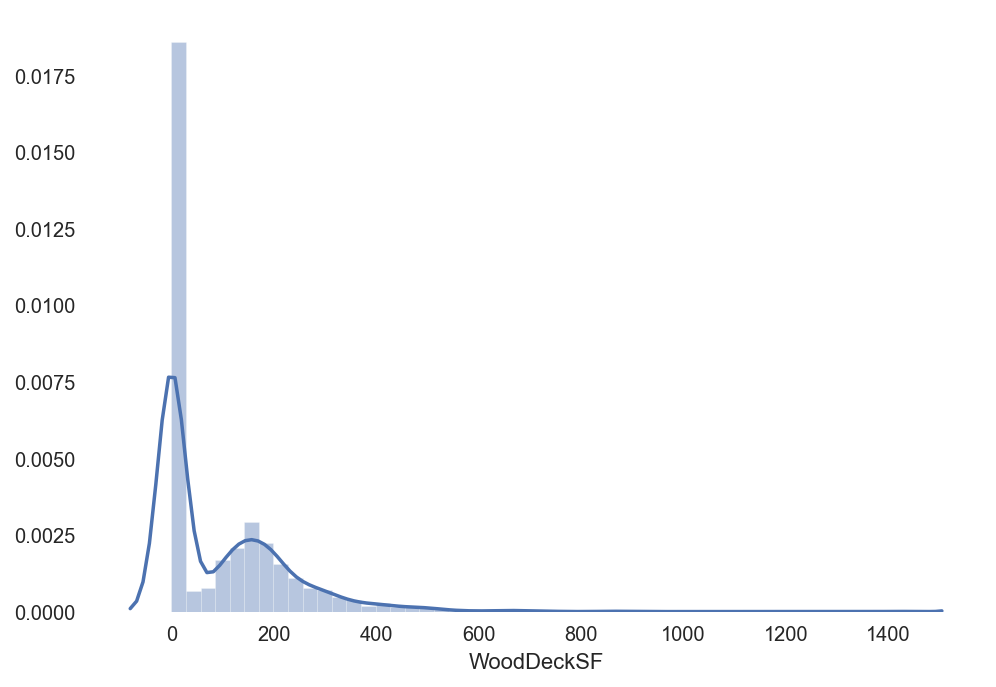

---------- 

Skewed features: OpenPorchSF


---------- 



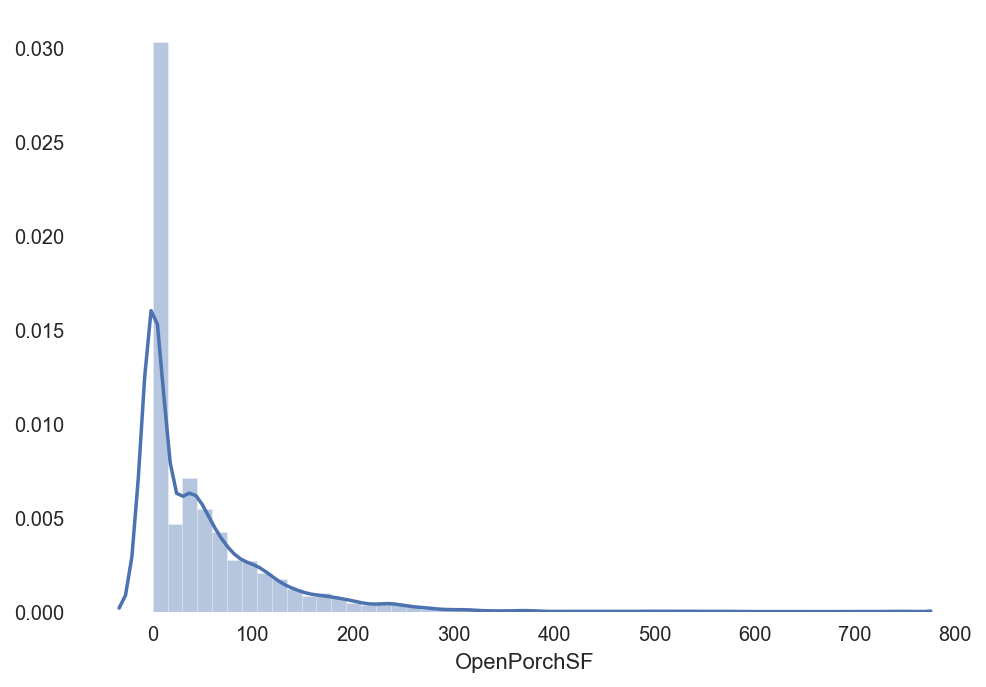

---------- 



In [214]:
#skewed_feats = skewed_feats.drop(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 
 #                                 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'])

for x in skewed_feats:

    print('Skewed features:', x)
    print('\n')
    print('-'*10, '\n')
    sns.distplot(all_data[x], color="b");
    ax.xaxis.grid(False)
    ax.set(ylabel="Frequency")
    ax.set(xlabel="SalePrice")
    ax.set(title="SalePrice distribution")
    plt.show();
    print('-'*10, '\n')

We can clearly see that those feature are skewed, we need to deal with that ! Let's do it.

In [290]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Skewed features: MSSubClass


---------- 



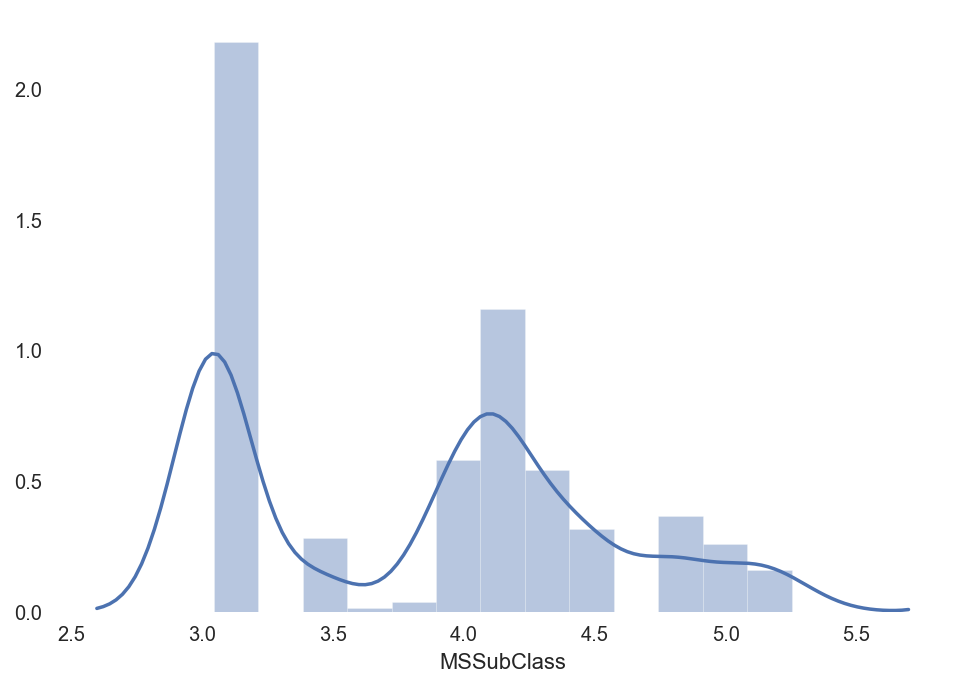

---------- 

Skewed features: LotFrontage


---------- 



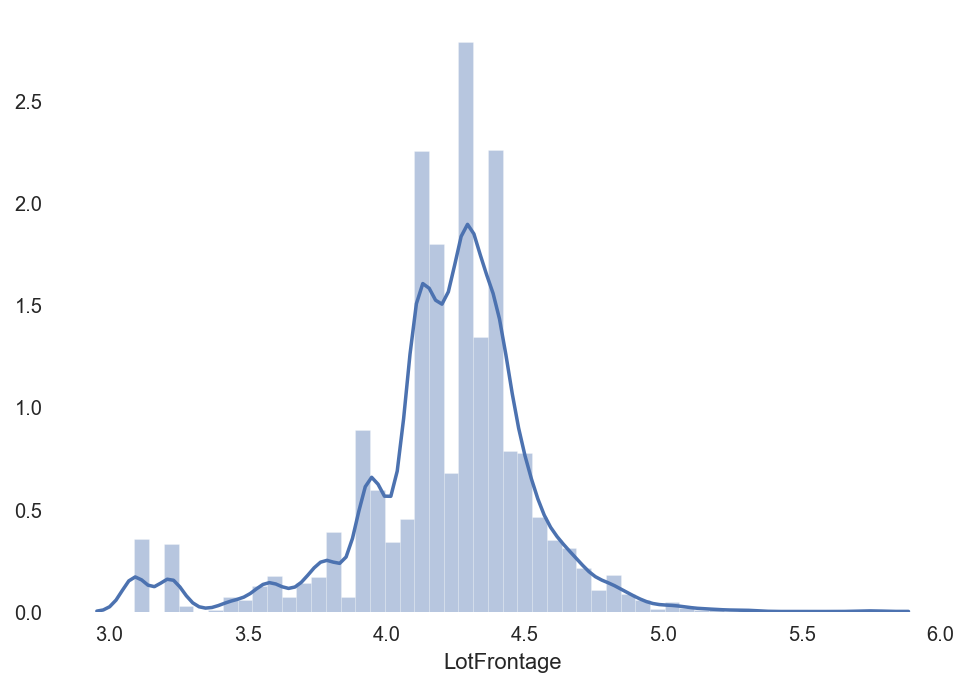

---------- 

Skewed features: LotArea


---------- 



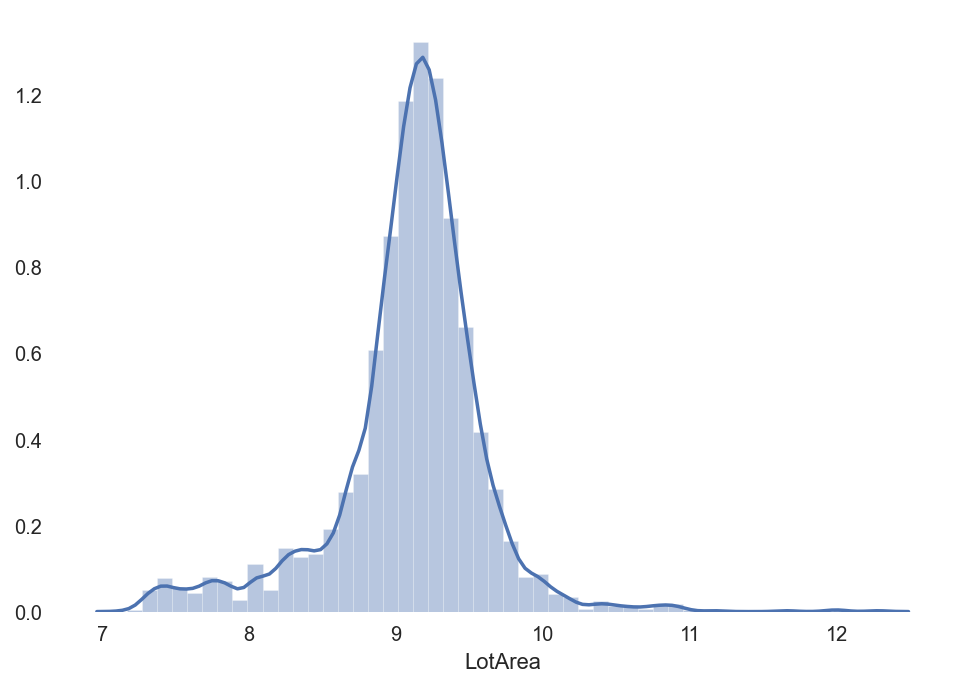

---------- 

Skewed features: MasVnrArea


---------- 



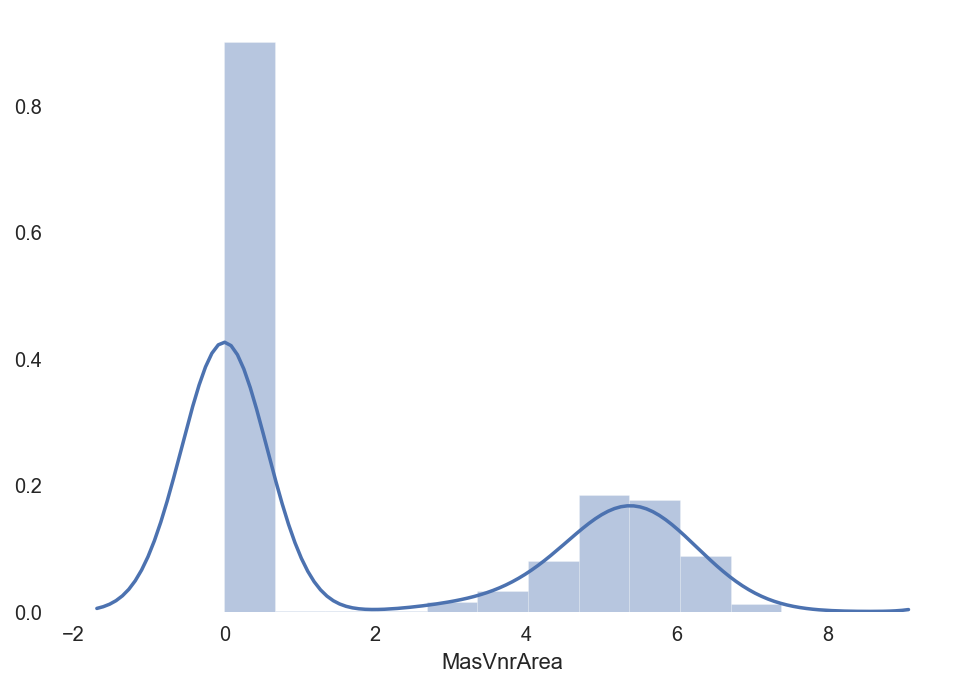

---------- 

Skewed features: BsmtFinSF1


---------- 



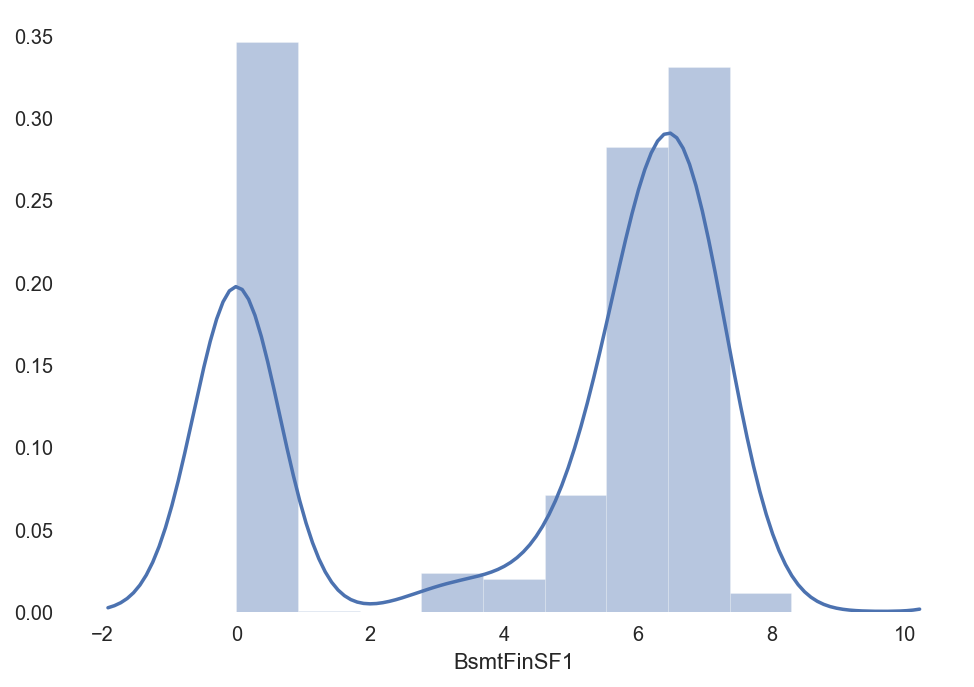

---------- 

Skewed features: BsmtUnfSF


---------- 



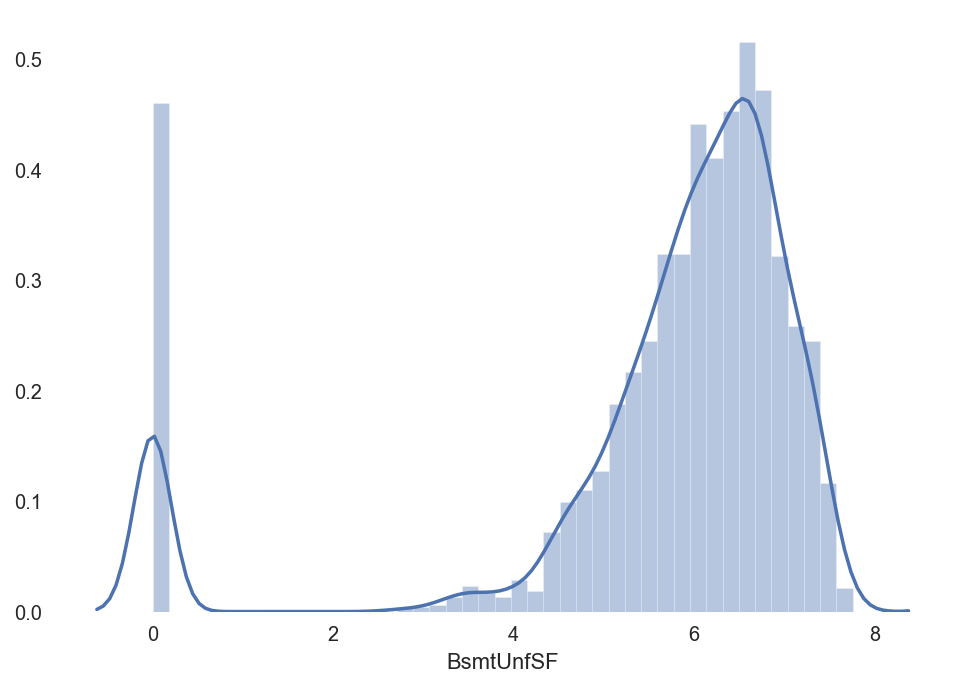

---------- 

Skewed features: 2ndFlrSF


---------- 



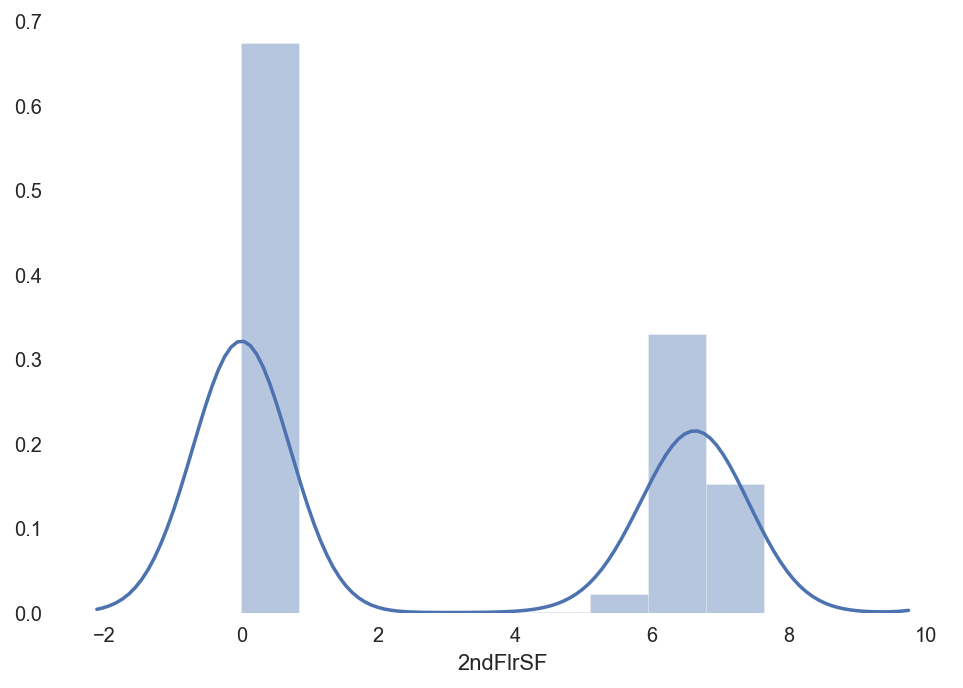

---------- 

Skewed features: GrLivArea


---------- 



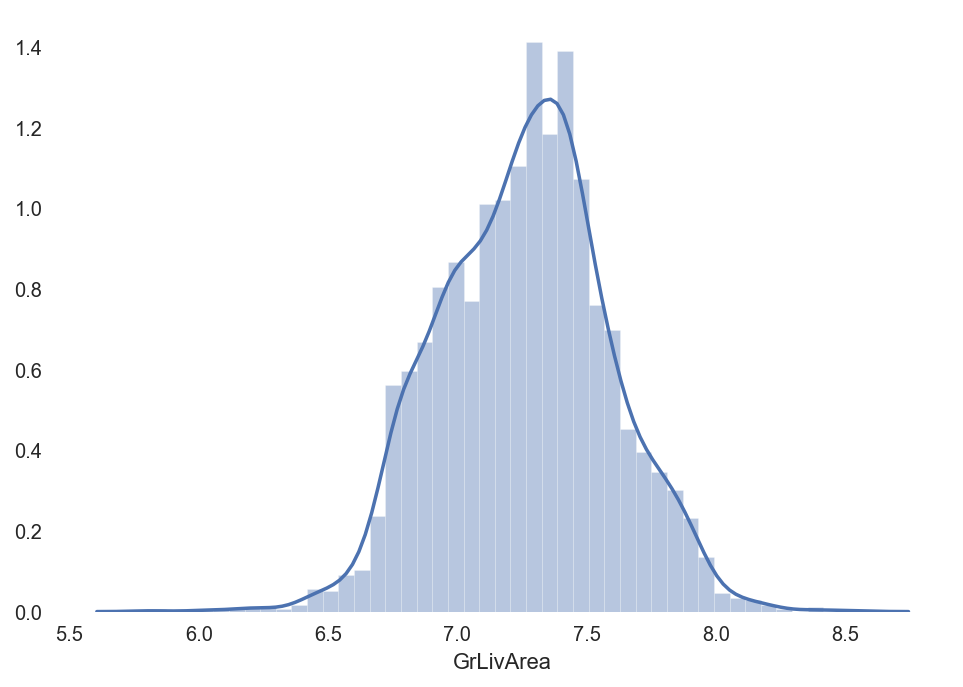

---------- 

Skewed features: WoodDeckSF


---------- 



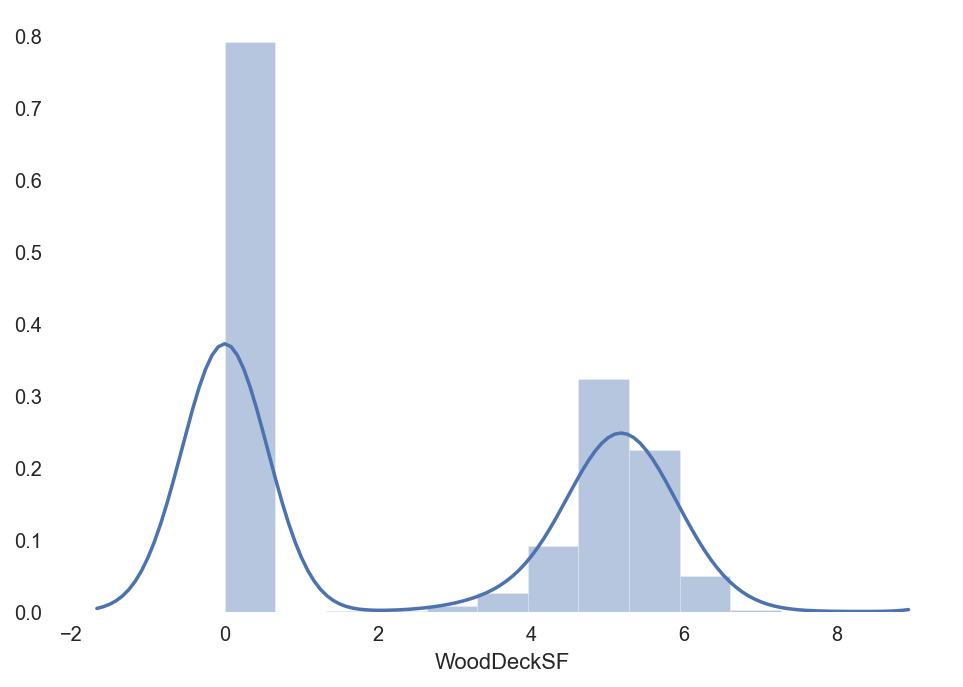

---------- 

Skewed features: OpenPorchSF


---------- 



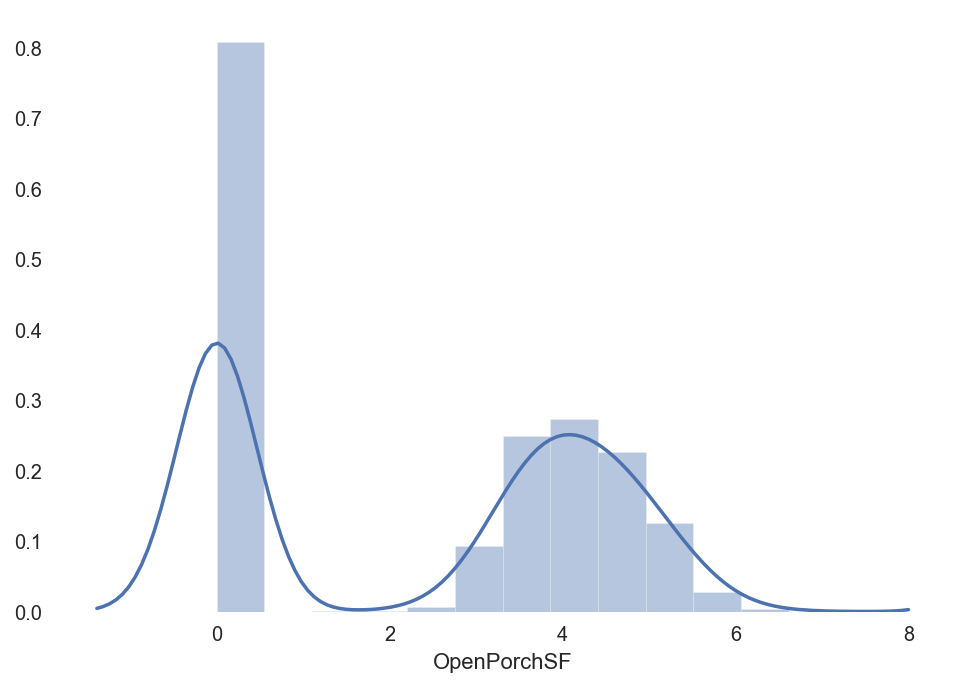

---------- 



In [230]:
#skewed_feats = skewed_feats.drop(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 
 #                                 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'])


for x in skewed_feats:

    print('Skewed features:', x)
    print('\n')
    print('-'*10, '\n')
    sns.distplot(all_data[x], color="b");
    ax.xaxis.grid(False)
    ax.set(ylabel="Frequency")
    ax.set(xlabel="SalePrice")
    ax.set(title="SalePrice distribution")
    plt.show();
    print('-'*10, '\n')

After these log transformation, most of our features have a smaller skewness.

**Categorical values**

We need to transform MSSubClass, MoSold and YrSold into categorical features.

In [291]:
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
190: 'SubClass_190'}})

In [292]:
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
190: 'SubClass_190'}})

In [293]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Ordered categorical features**

("Very bad", "Bad", "okay", "Good", "Amazing") need to be encoded as numerical ordered values (0->4 for example).

In [294]:
from pandas.api.types import CategoricalDtype

# Categorical values
# Ordered
all_data["BsmtCond"] = pd.Categorical(all_data["BsmtCond"], categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["BsmtExposure"] = pd.Categorical(all_data["BsmtExposure"], categories=['No','Mn','Av','Gd'],ordered=True)
all_data["BsmtFinType1"] = pd.Categorical(all_data["BsmtFinType1"],categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True)
all_data["BsmtFinType2"] = pd.Categorical(all_data["BsmtFinType2"],categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True)
all_data["BsmtQual"] = pd.Categorical(all_data["BsmtQual"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["ExterCond"] = pd.Categorical(all_data["ExterCond"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["ExterQual"] = pd.Categorical(all_data["ExterQual"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["Fence"] = pd.Categorical(all_data["Fence"],categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True)
all_data["FireplaceQu"] = pd.Categorical(all_data["FireplaceQu"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["Functional"] = pd.Categorical(all_data["Functional"],categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True)
all_data["GarageCond"] = pd.Categorical(all_data["GarageCond"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["GarageFinish"] = pd.Categorical(all_data["GarageFinish"],categories=['No','Unf','RFn','Fin'],ordered=True)
all_data["GarageQual"] = pd.Categorical(all_data["GarageQual"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["HeatingQC"] = pd.Categorical(all_data["HeatingQC"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["KitchenQual"] = pd.Categorical(all_data["KitchenQual"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
all_data["PavedDrive"] = pd.Categorical(all_data["PavedDrive"],categories=['N','P','Y'],ordered=True)
all_data["PoolQC"] = pd.Categorical(all_data["PoolQC"],categories=['No','Fa','TA','Gd','Ex'],ordered=True)

**Create new meta features**

In [296]:
all_data['TotalSF']=all_data['TotalBsmtSF']  + all_data['2ndFlrSF']

In [297]:
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (0.5*all_data['BsmtHalfBath']) + (0.5*all_data['HalfBath'])

In [298]:
all_data['YrBltAndRemod']=all_data['YearBuilt']+(all_data['YearRemodAdd']/2)

In [299]:
all_data['Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])

Also We create extra features in order to categorize data with and without a feature

For example:

'HasPool' is 1 if you have pool and 0 if you don't have a pool

In [300]:
all_data['Has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFirePlace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFlr']=all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt']=all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [301]:
all_data['LotArea'] = all_data['LotArea'].astype(np.int64)
all_data['MasVnrArea'] = all_data['MasVnrArea'].astype(np.int64)

What about non ordered categorical features ? Let's transform them with into dummies variables.

Since we are working on a regression problem, we have to watch out for multicollinearities. That's why i choosed to set the argument drop_firt=True, to derive n-1 features from a feature with n different categories.

This help to reduce the collinearity .

In [302]:
all_data = pd.get_dummies(all_data,drop_first=True)

all_data.shape

(2917, 292)

**Create training and test set**

In [303]:
X = all_data[:train.shape[0]]
y = train.SalePrice
    
Test = all_data[train.shape[0]:]

In [304]:
print(X.shape)
print(Test.shape)
print(y.shape)

(1458, 292)
(1459, 292)
(1458,)


<a id="4"></a> <br>
## Modeling
Now we are going to visualize which model seems performs well with our function rmse_cv, let's try first the most well known : Linear Regression :

**Linear Regression**

In order to perform Linear Regression, we need to check some assumptions like :
    
- Mean of Residuals
- Check for Homoscedasticity
- Check for Normality of error terms/residuals

And so on, that's why I made a entire section just for Linear Regression. To took the time and do things right !

Those assumptions require us to perform the regression before we can even check for them. So let's perform regression on it

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0,test_size=0.25)

In [39]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
import math
import sklearn.metrics as sklm

regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_train)

*Mean of Residuals*

Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.

In [41]:
residuals = y_train.values-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -3.434073194558764e-15


That's quite close to zero, so that's good !

*Check for Homoscedasticity*

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms

First of all, let's see with a graph.

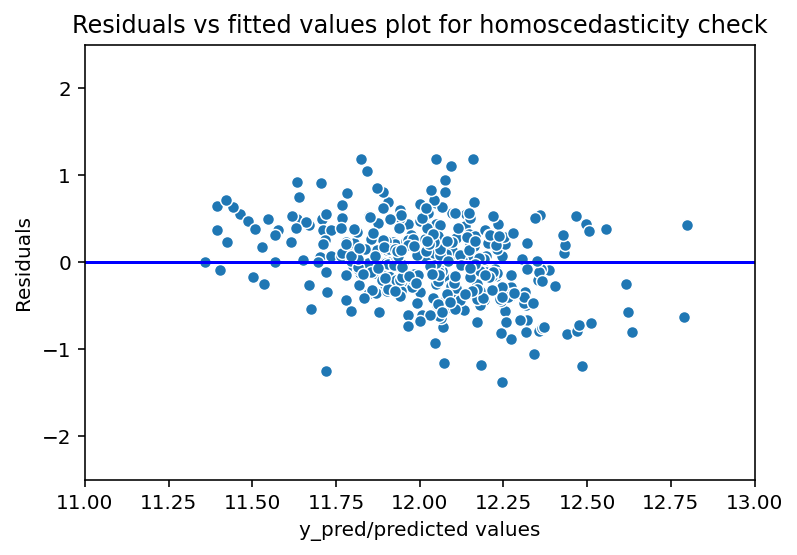

In [31]:
p = sns.scatterplot(y_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-2.5,2.5)
plt.xlim(11,13)
p = sns.lineplot([10,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Now we will be applying tests.
A tip is to keep in mind that if we want 95% confidence on our findings and tests then the p-value should be less than 0.05 to be able to reject the null hypothesis. Remember, a researcher or data scientist would always aim to reject the null hypothesis.

*Goldfeld Quandt Test*

Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic
Alternative Hypothesis: Error terms are heteroscedastic.

In [43]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.1171517846695997), ('p-value', 0.17006576515806723)]

Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic. Good.

*Check for Normality of error terms/residuals*

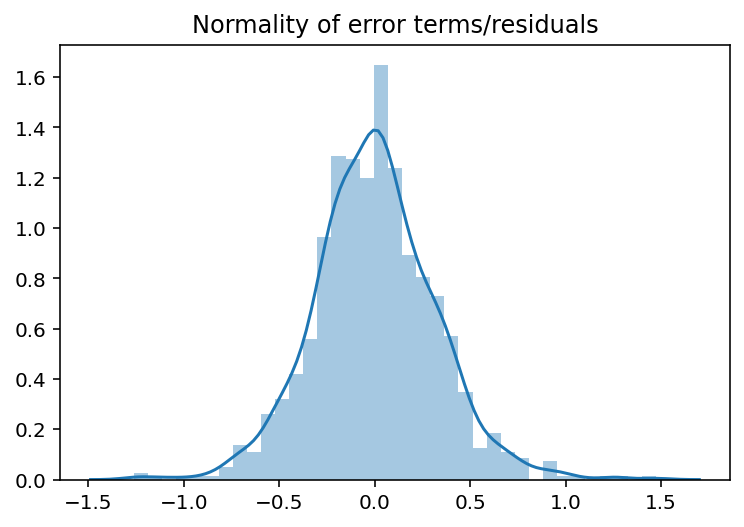

In [44]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms are pretty much normally distributed for the number of test points we took. That's good !

*No perfect multicollinearity*

In regression, multicollinearity refers to the extent to which independent variables are correlated. Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.

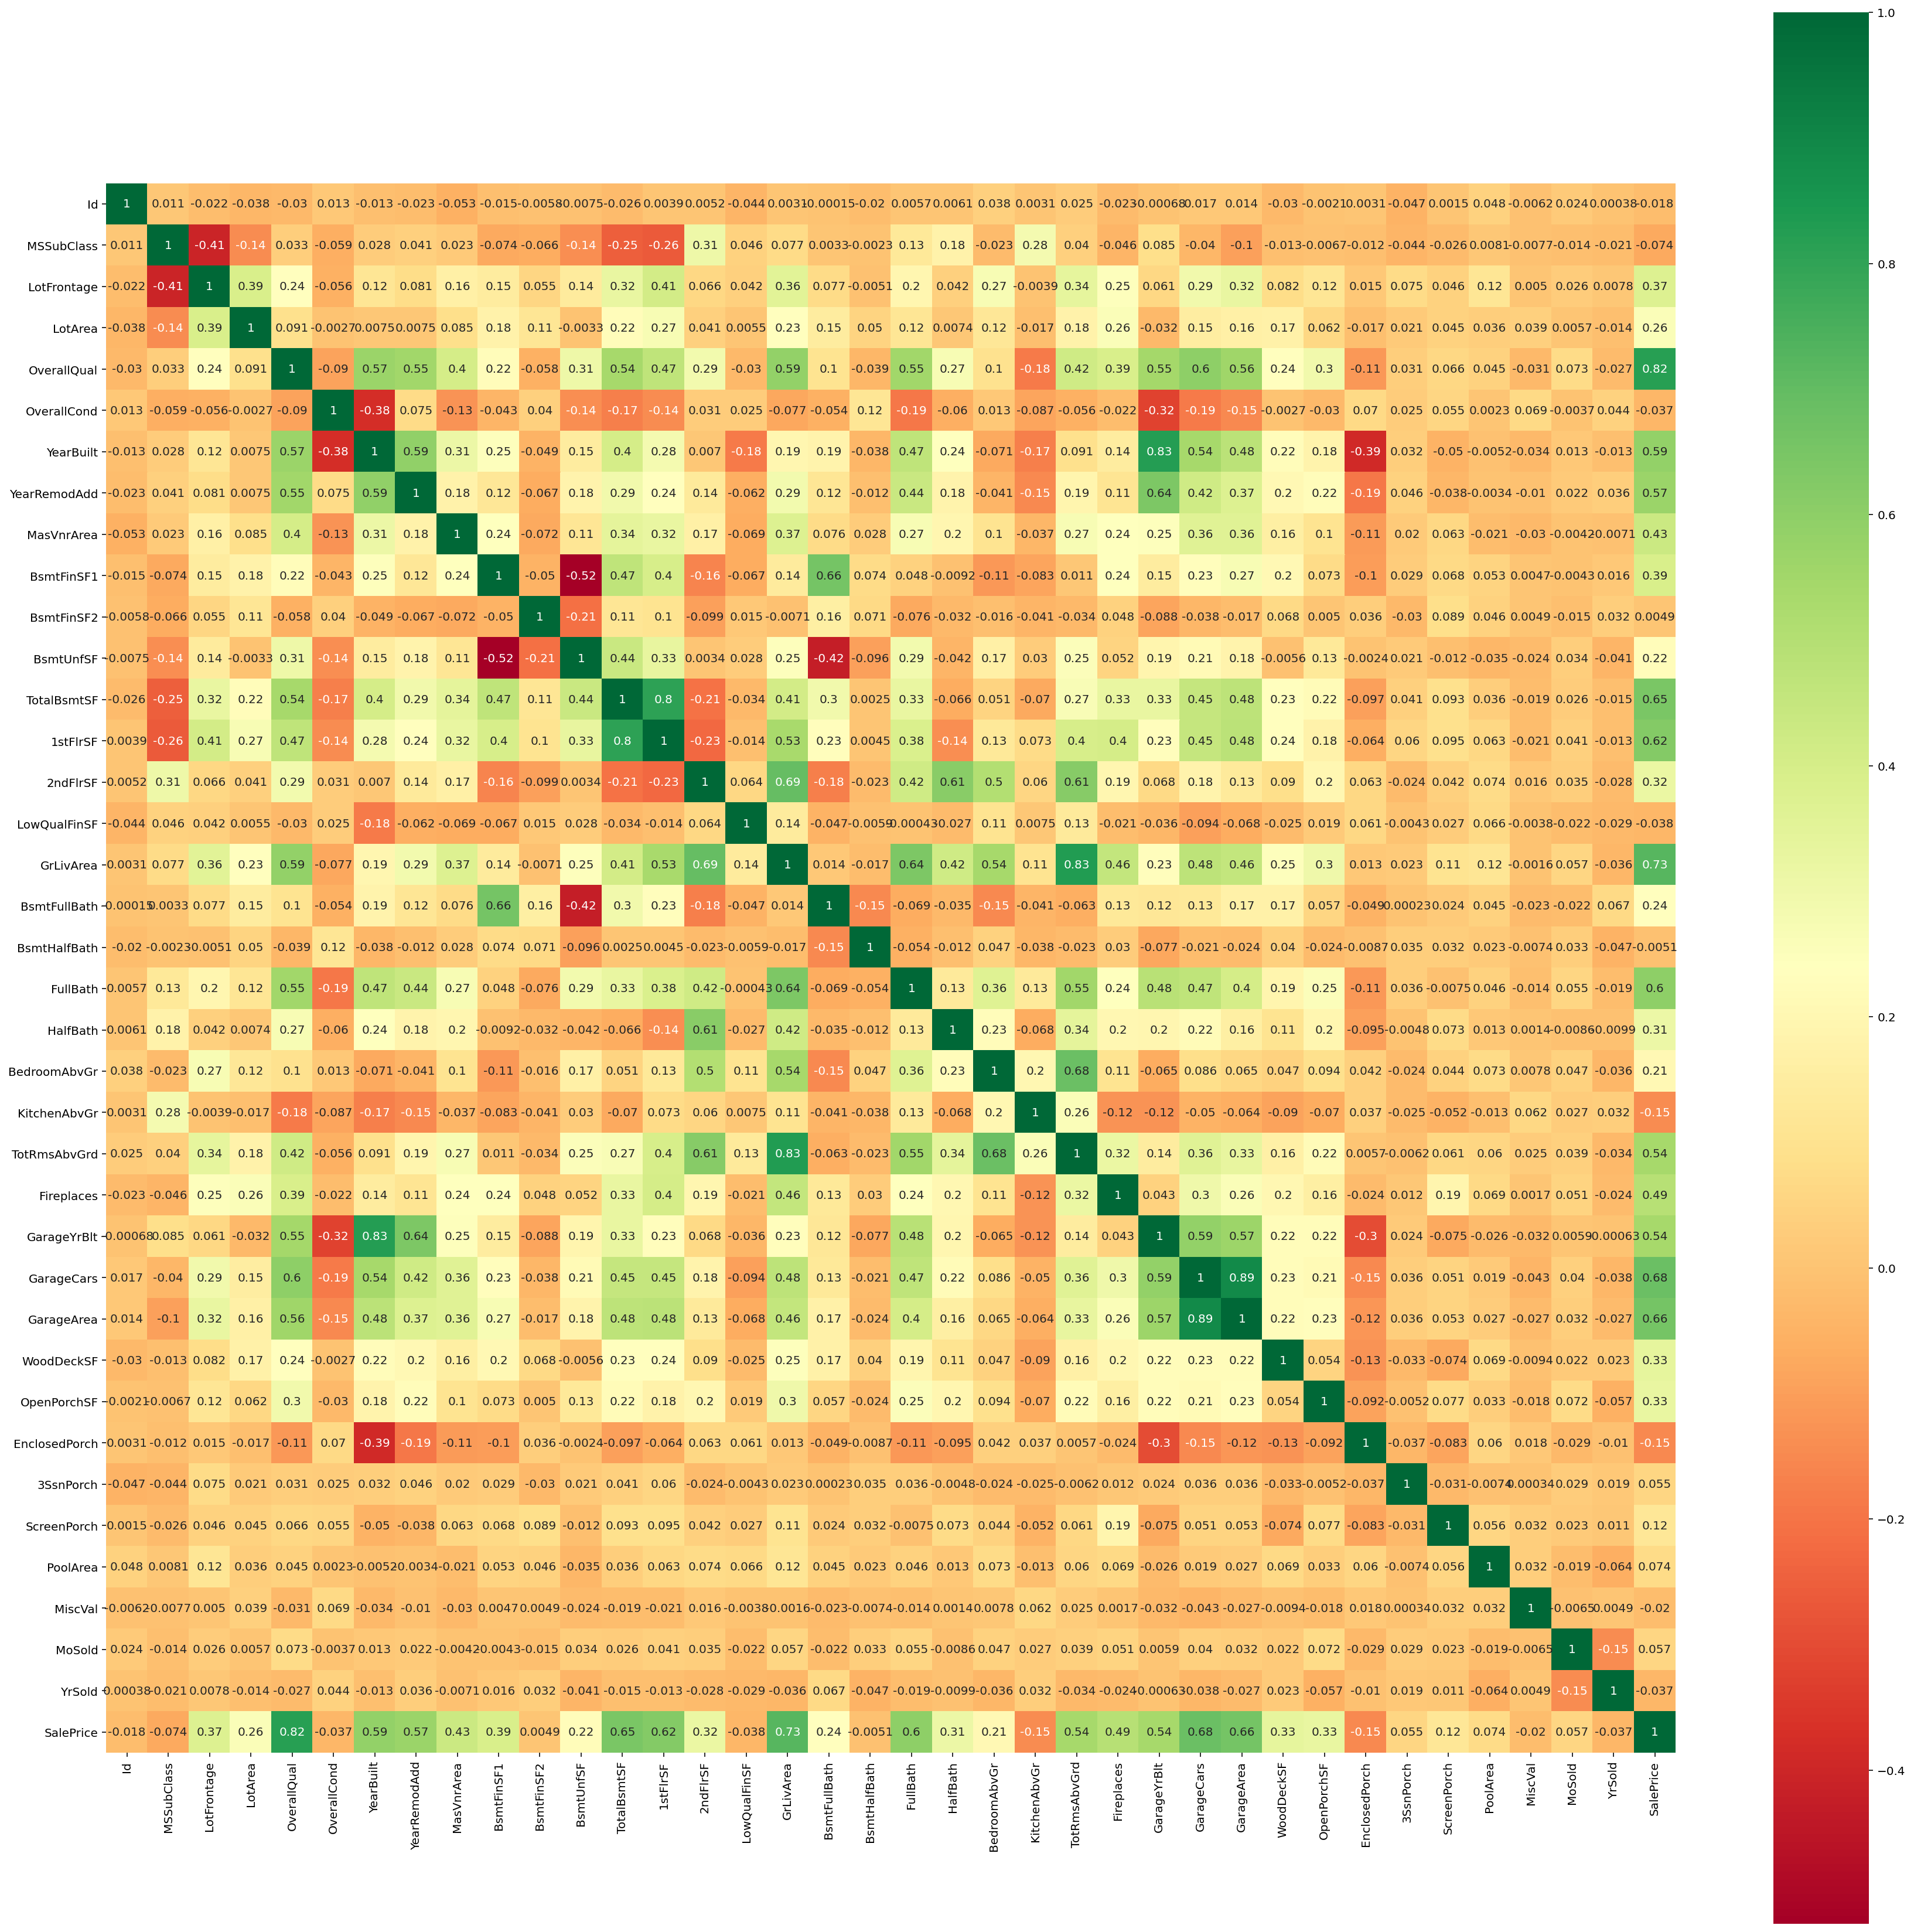

In [49]:
plt.figure(figsize=(30,30))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(train.corr(), annot=True,cmap='RdYlGn',square=True)  # seaborn has very simple solution for heatmap

Correlation within dependent variables is what we need to look for and avoid. This data doesn't contain perfect multicollinearity among independent variables. In case there was any then we would try to remove one of the correlated variables depending on which was more important to our regression model

Linear Regression seems to be well fitted to our data. We will keep that in mind. Now we will try a bunch of model and see which one perform well.

**All models**

In [305]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [308]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error" , cv=5))
    return (rmse)

**all models**

Let's see for all of the known model the rmse mean :

In [ ]:
scores = {}

scores['xgboost'] = rmse_cv(XGBRegressor())

scores['LinearRegression'] = rmse_cv(LinearRegression())

scores['SGDRegressor'] = rmse_cv(SGDRegressor())

scores['Lasso'] = rmse_cv(Lasso())

scores['Ridge'] = rmse_cv(Ridge())

scores['PassiveAggressiveRegressor'] = rmse_cv(PassiveAggressiveRegressor())

scores['HuberRegressor'] = rmse_cv(HuberRegressor())

scores['TheilSenRegressor'] = rmse_cv(TheilSenRegressor())

scores['RandomForestRegressor'] = rmse_cv(RandomForestRegressor())

scores['ExtraTreesRegressor'] = rmse_cv(ExtraTreesRegressor())

scores['AdaBoostRegressor'] = rmse_cv(AdaBoostRegressor())

scores['GradientBoostingRegressor'] = rmse_cv(GradientBoostingRegressor())

scores['DecisionTreeRegressor'] = rmse_cv(DecisionTreeRegressor())

scores['ElasticNet'] = rmse_cv(ElasticNet())

scores['SVR'] = rmse_cv(SVR())


In [310]:
model_rmse = pd.DataFrame(scores).mean()
model_rmse = model_rmse.sort_values(ascending=True)
print('Model scores\n{}'.format(model_rmse))

Model scores
Ridge                         1.187725e-01
xgboost                       1.235067e-01
GradientBoostingRegressor     1.242038e-01
TheilSenRegressor             1.247363e-01
ExtraTreesRegressor           1.379902e-01
RandomForestRegressor         1.383996e-01
HuberRegressor                1.611306e-01
AdaBoostRegressor             1.691027e-01
DecisionTreeRegressor         2.005728e-01
ElasticNet                    2.531506e-01
Lasso                         2.569822e-01
SVR                           2.710605e-01
PassiveAggressiveRegressor    2.716674e-01
LinearRegression              9.955667e+03
SGDRegressor                  5.770721e+15
dtype: float64


So let's focus on GradientBoostingRegressor, XGBoost and Ridge !

For now let's create our Ridge model

#### Ridge

In [311]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data. We need to find a compromise !

In [312]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

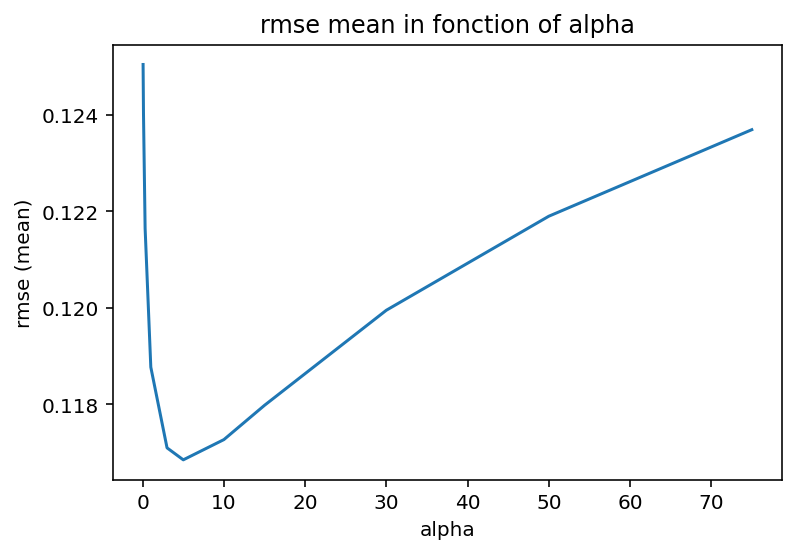

In [313]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "rmse mean in fonction of alpha")
plt.xlabel('alpha')
plt.ylabel('rmse (mean)');

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [314]:
cv_ridge.min()

0.11685197080749117

So for the Ridge regression we get a rmse of about 0.116

In [315]:
model_ridge = Ridge(alpha = 5).fit(X_train, y_train)

 Another neat thing about the Ridge is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [316]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)

In [317]:
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 21 variables and eliminated the other 0 variables


We can also take a look directly at what the most important coefficients are:

In [318]:
imp_coef = pd.concat([coef.sort_values().head(10),
                    coef.sort_values().tail(10)])

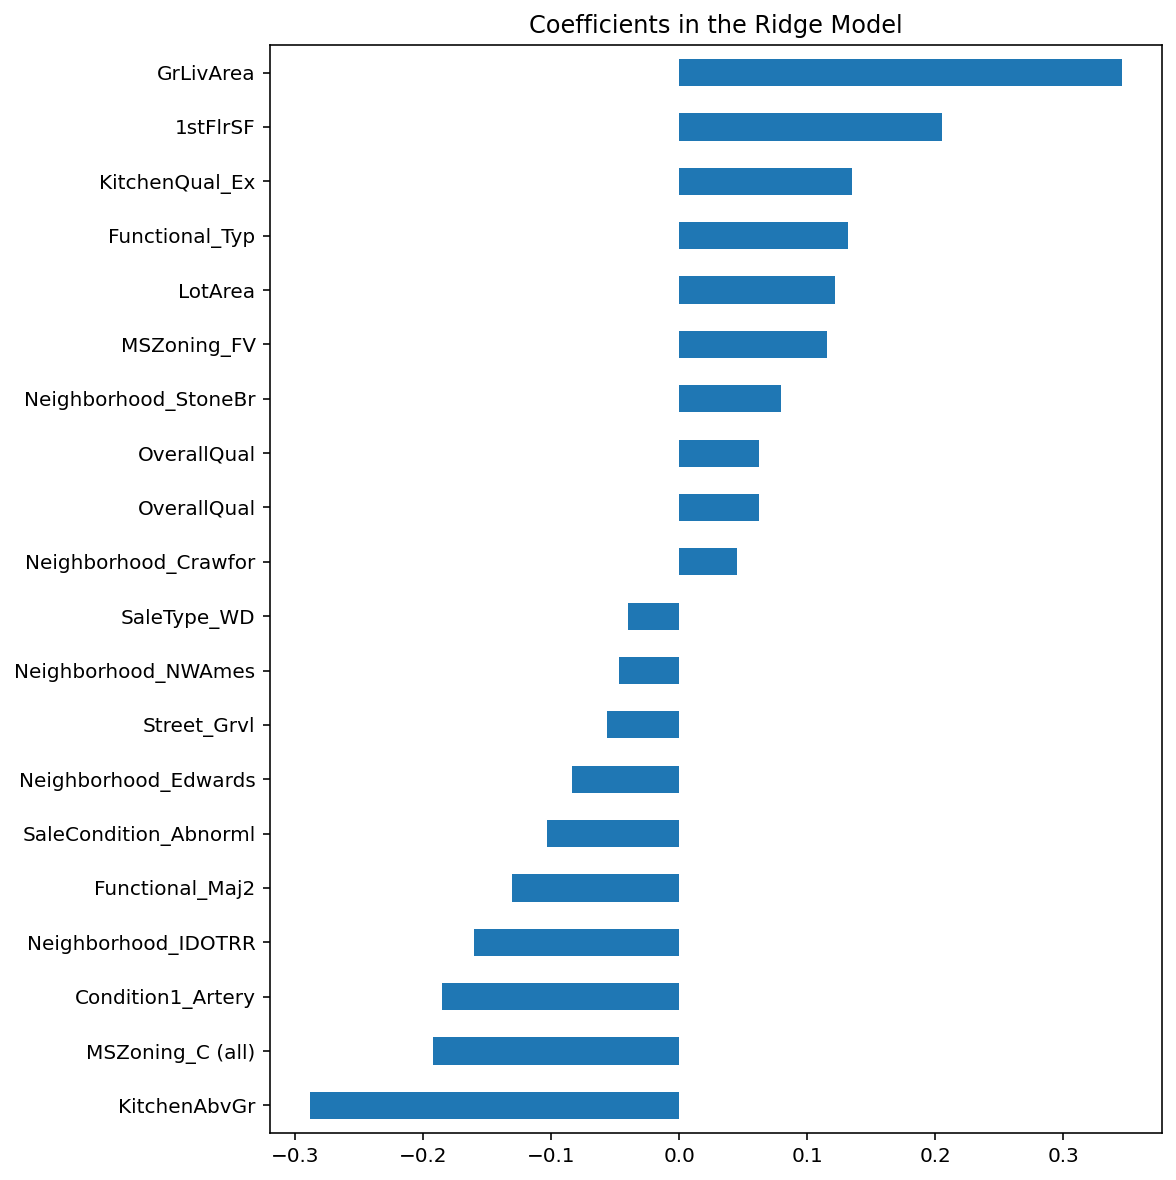

In [319]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely make sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

We also can interpret this kind of feature importance with the wonderful package LIME !

In [320]:
perm_import = PermutationImportance(model_ridge, random_state=1).fit(X_train, y_train)

# visualize the results
eli5.show_weights(perm_import, top=15, feature_names = X_train.columns.tolist())

We can see some similarities, but also some difference. It's always good to see several features importances methods to see different vision.

Let's look at the residuals as well:

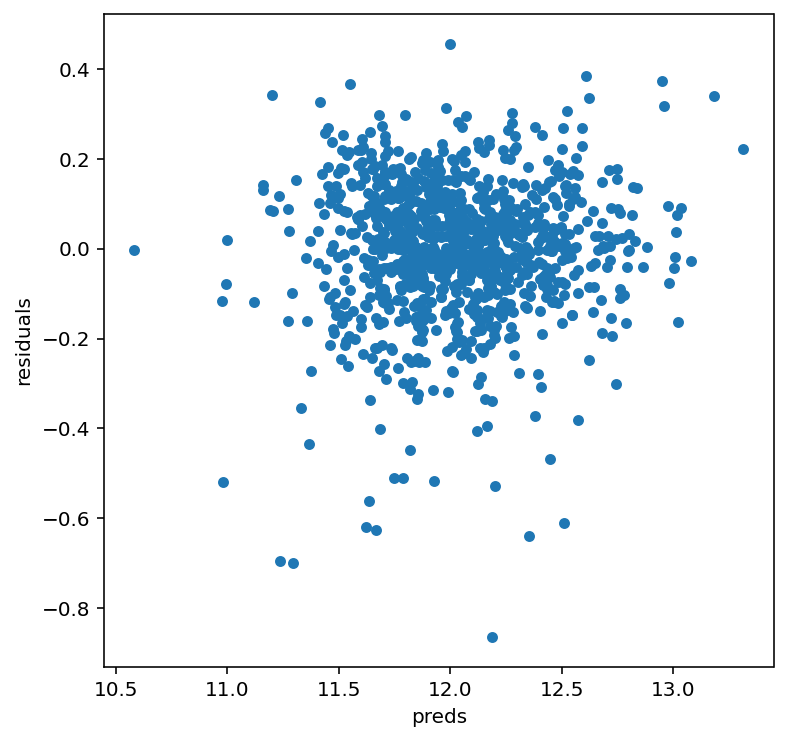

In [322]:

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter");

The residual plot looks pretty good.

#### XGBoost

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [79]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_tr, y_tr, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [80]:
my_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)>

In [82]:
rmse_cv(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)).mean()

C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.12596044801636225

Our results are enhanced with our hyperparameters tuning

#### GradientBoostingRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid={'n_estimators':[100], 
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17],
            'max_features':[1.0,0.3,0.1] }

GB = GradientBoostingRegressor()
clf = GridSearchCV(GB, param_grid, cv=5)
clf.fit(X, y)

In [27]:
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 100}


In [28]:

rmse_cv(GradientBoostingRegressor
        (learning_rate= 0.1, max_depth= 4, max_features= 0.3, min_samples_leaf= 3, n_estimators= 100)).mean()

0.12558915071277088

GridSearchCV improve slightly our accuracy. Sometime it's not worth the time, but sometime it is.

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score.

In [29]:
#GradientBoostingRegressor 

GB = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 4, max_features= 0.3, min_samples_leaf= 3, n_estimators= 100)
GB.fit(X_train, y)
gb_preds = np.expm1(GB.predict(X_test))


# XGBRegressor

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model_xgb.fit(X_tr, y_tr, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)

xgb_preds = np.expm1(model_xgb.predict(X_test))

#RIDGE

model_ridge = Ridge(alpha = 10)
model_ridge.fit(X_train, y)

ridge_preds = np.expm1(model_ridge.predict(X_test))

C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [30]:
preds = 0.4*gb_preds + 0.3*xgb_preds + 0.3* ridge_preds

In [31]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("solution.csv", index = False)

We obtained with these models a 0.12144 submission RMSE, which is quite good, we are well place on the leaderboard but maybe we can do better ?



<a id="5"></a> <br>
## Function to wrap up

Before moving to the next section of this work, I would like to introduce a function that does all the work we did above in details just with one line of code. The function does all the regression pipeline:

- Import the data
- Log transform our target variable
- Drop the outliers
- Handle the missing data
- Deal with skewness
- Deal with categorical ordered/non ordered
- Split the data to train/test
- Compute metrics
- Return features importances
- Predict the target
- Return a file for submit to Kaggle

And you just need to precise one of the three models we implemented earlier (Ridge, XgbRegressor, GradientBoostingRegressor)

In [325]:
def function(model, model_name):

    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    
    #skew
    train["SalePrice"] = np.log1p(train["SalePrice"])
    
    # Remove outliers
    train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
    train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
    train.reset_index(drop=True, inplace=True)
    
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
    
    #handle missing value
    all_data = handle_missing(all_data)
    
    #log transform skewed numeric features:
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    
    all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
    45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
    75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
    120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
    190: 'SubClass_190'}})
    
    all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
    45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
    75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
    120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
    190: 'SubClass_190'}})
    
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)
    
    all_data["BsmtCond"] = pd.Categorical(all_data["BsmtCond"], categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["BsmtExposure"] = pd.Categorical(all_data["BsmtExposure"], categories=['No','Mn','Av','Gd'],ordered=True)
    all_data["BsmtFinType1"] = pd.Categorical(all_data["BsmtFinType1"],categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True)
    all_data["BsmtFinType2"] = pd.Categorical(all_data["BsmtFinType2"],categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True)
    all_data["BsmtQual"] = pd.Categorical(all_data["BsmtQual"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["ExterCond"] = pd.Categorical(all_data["ExterCond"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["ExterQual"] = pd.Categorical(all_data["ExterQual"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["Fence"] = pd.Categorical(all_data["Fence"],categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True)
    all_data["FireplaceQu"] = pd.Categorical(all_data["FireplaceQu"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["Functional"] = pd.Categorical(all_data["Functional"],categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True)
    all_data["GarageCond"] = pd.Categorical(all_data["GarageCond"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["GarageFinish"] = pd.Categorical(all_data["GarageFinish"],categories=['No','Unf','RFn','Fin'],ordered=True)
    all_data["GarageQual"] = pd.Categorical(all_data["GarageQual"],categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["HeatingQC"] = pd.Categorical(all_data["HeatingQC"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["KitchenQual"] = pd.Categorical(all_data["KitchenQual"],categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
    all_data["PavedDrive"] = pd.Categorical(all_data["PavedDrive"],categories=['N','P','Y'],ordered=True)
    all_data["PoolQC"] = pd.Categorical(all_data["PoolQC"],categories=['No','Fa','TA','Gd','Ex'],ordered=True)
    
    all_data['TotalSF']=all_data['TotalBsmtSF']  + all_data['2ndFlrSF']
    
    all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (0.5*all_data['BsmtHalfBath']) + (0.5*all_data['HalfBath'])
    
    all_data['YrBltAndRemod']=all_data['YearBuilt']+(all_data['YearRemodAdd']/2)
    
    all_data['Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])
    
    all_data['Has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['HasFirePlace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    all_data['Has2ndFlr']=all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['HasBsmt']=all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    
    all_data['LotArea'] = all_data['LotArea'].astype(np.int64)
    all_data['MasVnrArea'] = all_data['MasVnrArea'].astype(np.int64)

    all_data = pd.get_dummies(all_data).reset_index(drop=True)
    
    # Remove any duplicated column names
    all_data = all_data.loc[:,~all_data.columns.duplicated()]
    
    X = all_data[:train.shape[0]]
    y = train.SalePrice
    
    Test = all_data[train.shape[0]:]


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)
    

    #modeling
    
    if model == Ridge:
   
        model=model(alpha = 10).fit(X_train,y_train)

        y_pred= model.predict(X_test)

    
        print("The  RMSE score achieved with {} is {}".format(model_name, str(math.sqrt(sklm.mean_squared_error(y_test, y_pred)))))
        
        coef = pd.Series(model.coef_, index = X_train.columns)
        
        print()
        print('Our most valuable features with {} are :'.format(model_name))
        print()
        print(coef.sort_values(ascending = False).head(10))
        print()
        print(coef.sort_values(ascending = False).tail(10))
        
        #submission
        model_preds = np.expm1(model.predict(Test))
        
        solution = pd.DataFrame({"id":test.Id, "SalePrice":model_preds})
        solution.to_csv("solution.csv", index = False)
        print()
        print("Submission file created !")

        
    
    elif model == XGBRegressor:

        model = model(n_estimators=1000, learning_rate=0.05).fit(X_train, y_train)
        
        y_pred=model.predict(X_test)
        
        print("The  RMSE score achieved with {} is {}".format(model_name, str(math.sqrt(sklm.mean_squared_error(y_test, y_pred)))))
        
        
        coef = pd.Series(model.feature_importances_, index = X_train.columns)
        
        print()
        print('Our most valuable features with {} are :'.format(model_name))
        print()
        print(coef.sort_values(ascending = False).head(10))
        
        #submission
        model_preds = np.expm1(model.predict(Test))
        
        solution = pd.DataFrame({"id":test.Id, "SalePrice":model_preds})
        solution.to_csv("solution.csv", index = False)
        
        print()
        print("Submission file created !")
        
    elif model == GradientBoostingRegressor:

        model = model(learning_rate= 0.1, max_depth= 4, max_features= 0.3, min_samples_leaf= 3, n_estimators= 100).fit(X_train, y_train)
        
        y_pred=model.predict(X_test)
        
        print("The  RMSE score achieved with {} is {}".format(model_name, str(math.sqrt(sklm.mean_squared_error(y_test, y_pred)))))
        
        
        coef = pd.Series(model.feature_importances_, index = X_train.columns)
        
        print()
        print('Our most valuable features with {} are :'.format(model_name))
        print()
        print(coef.sort_values(ascending = False).head(10))
        
        #submission
        model_preds = np.expm1(model.predict(Test))
        
        solution = pd.DataFrame({"id":test.Id, "SalePrice":model_preds})
        solution.to_csv("solution.csv", index = False)
        
        print()
        print("Submission file created !")

Let's try our function !

In [329]:
function(Ridge, 'Ridge')

The  RMSE score achieved with Ridge is 0.11211841966220779

Our most valuable features with Ridge are :

GrLivArea               0.141327
1stFlrSF                0.109848
Neighborhood_Crawfor    0.082225
MSZoning_FV             0.061644
Functional_Typ          0.061466
Neighborhood_StoneBr    0.059289
KitchenQual_Ex          0.057105
Exterior1st_BrkFace     0.056895
SaleType_ConLD          0.049535
OverallQual             0.047968
dtype: float64

Street_Grvl             -0.035901
CentralAir_N            -0.036066
Condition1_Artery       -0.037079
Neighborhood_NWAmes     -0.038007
SaleType_WD             -0.042105
Neighborhood_IDOTRR     -0.045110
SaleCondition_Abnorml   -0.046603
Neighborhood_Edwards    -0.049722
Functional_Maj2         -0.052809
MSZoning_C (all)        -0.106363
dtype: float64

Submission file created !


In [327]:
function(XGBRegressor, 'XGBRegressor')

[18:38:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The  RMSE score achieved with XGBRegressor is 0.11511574437089014

Our most valuable features with XGBRegressor are :

GarageCars           0.211896
GarageType_Attchd    0.071323
GarageCond_TA        0.046178
Fireplaces           0.045899
KitchenQual_Ex       0.037462
TotalBath            0.036438
TotalSF              0.029042
MSZoning_RL          0.027495
CentralAir_N         0.027127
GrLivArea            0.025712
dtype: float32

Submission file created !


In [328]:
function(GradientBoostingRegressor, 'GradientBoostingRegressor')

The  RMSE score achieved with GradientBoostingRegressor is 0.11786481903459996

Our most valuable features with GradientBoostingRegressor are :

OverallQual    0.193449
GrLivArea      0.140595
YearBuilt      0.112741
FullBath       0.062854
TotalBath      0.061123
GarageCars     0.038422
TotalSF        0.037934
GarageArea     0.030735
TotalBsmtSF    0.030578
1stFlrSF       0.029856
dtype: float64

Submission file created !


Let's try a method which I've seen in a Kernel on Kaggle, and see if I could increase my position on the leaderboard. If not, too bad, I could enhanced my skill at least !

<a id="6"></a> <br>
## Setup our next models

**Blending and stacking**

Let's try to stack and blend our model, in Kaggle's competition, this methods work wery well sometimes.

In [50]:
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.regressor import StackingCVRegressor

# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [51]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_test), np.array(y))

stack_gen


In [52]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_test, y)

lightgbm


In [53]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X_test, y)

xgboost


In [54]:
print('Svr')
svr_model_full_data = svr.fit(X_test, y)

Svr


In [55]:
print('Ridge')
ridge_model_full_data = ridge.fit(X_test, y)

Ridge


In [56]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [57]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * np.expm1(ridge_model_full_data.predict(X))) + \
            (0.2 * np.expm1(svr_model_full_data.predict(X))) + \
            (0.1 * np.expm1(gbr_model_full_data.predict(X))) + \
            (0.1 * np.expm1(xgb_model_full_data.predict(X))) + \
            (0.1 * np.expm1(lgb_model_full_data.predict(X))) + \
            (0.05 * np.expm1(rf_model_full_data.predict(X))) + \
            (0.35 * np.expm1(stack_gen_model.predict(np.array(X)))))

solution2 = pd.DataFrame({"id":test.Id, "SalePrice":blended_predictions(X_test)})

solution2.to_csv("solution2.csv", index = False)

That's doesn't improve our submission RMSE, too bad. At least, we tried ! Maybe our model is too specific and overfit ?

So now I would like to test my models but with a less variable, to gain some time and see if it decrease my performances.

**Models with less variable**

In [196]:
import eli5
from IPython.display import display, HTML

In [246]:
function(Ridge, 'Ridge')

The  RMSE score achieved with Ridge is 0.11057667341790704

Our most valuable features with Ridge are :

GrLivArea               0.147666
1stFlrSF                0.105914
Neighborhood_Crawfor    0.085941
LotArea                 0.079830
Functional_Typ          0.066818
Neighborhood_StoneBr    0.061214
Exterior1st_BrkFace     0.060413
MSZoning_FV             0.059462
KitchenQual_Ex          0.055785
OverallQual             0.048993
dtype: float64

KitchenAbvGr            -0.035088
Condition1_Artery       -0.036913
Street_Grvl             -0.039572
SaleType_WD             -0.041864
Neighborhood_NWAmes     -0.042409
Neighborhood_IDOTRR     -0.047198
SaleCondition_Abnorml   -0.049245
Neighborhood_Edwards    -0.053823
Functional_Maj2         -0.058192
MSZoning_C (all)        -0.109576
dtype: float64

Submission file created !


In [248]:
def function(train, test):
    
    #skew
    train["SalePrice"] = np.log1p(train["SalePrice"])
    
    # Remove outliers
    train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
    train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
    train.reset_index(drop=True, inplace=True)
    
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
    
    #handle missing value
    all_data = handle_missing(all_data)
    
    #log transform skewed numeric features:
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    
    all_data = pd.get_dummies(all_data).reset_index(drop=True)
    
    # Remove any duplicated column names
    all_data = all_data.loc[:,~all_data.columns.duplicated()]
    
    X = all_data[:train.shape[0]]
    y = train.SalePrice
    
    Test = all_data[train.shape[0]:]
    
    return X, y, Test


In [249]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X, y, Test = function(train, test)

In [250]:
X = X[['GrLivArea', '1stFlrSF', 'OverallQual', 'Neighborhood_Crawfor', 'LotArea',
       'Functional_Typ', 'Neighborhood_StoneBr', 'Exterior1st_BrkFace', 'MSZoning_FV', 'KitchenQual_Ex',
       'OverallQual', 'KitchenAbvGr', 'Condition1_Artery', 'Street_Grvl', 'SaleType_WD',
       'Neighborhood_NWAmes', 'Neighborhood_IDOTRR', 'SaleCondition_Abnorml', 'Neighborhood_Edwards', 'Functional_Maj2', 'MSZoning_C (all)']]

In [268]:
Test = Test[['GrLivArea', '1stFlrSF', 'OverallQual', 'Neighborhood_Crawfor', 'LotArea',
       'Functional_Typ', 'Neighborhood_StoneBr', 'Exterior1st_BrkFace', 'MSZoning_FV', 'KitchenQual_Ex',
       'OverallQual', 'KitchenAbvGr', 'Condition1_Artery', 'Street_Grvl', 'SaleType_WD',
       'Neighborhood_NWAmes', 'Neighborhood_IDOTRR', 'SaleCondition_Abnorml', 'Neighborhood_Edwards', 'Functional_Maj2', 'MSZoning_C (all)']]

In [252]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

In [262]:
model_ridge = Ridge(alpha = 10).fit(X_train,y_train)

In [266]:
y_pred=model_ridge.predict(X_test)

print("The  RMSE score achieved with is ", str(math.sqrt(sklm.mean_squared_error(y_test, y_pred))))       

The  RMSE score achieved with is  0.14931769369071565


In [269]:
model_preds = np.expm1(model_ridge.predict(Test))
        
solution = pd.DataFrame({"id":test.Id, "SalePrice":model_preds})
solution.to_csv("solution.csv", index = False)

That's slightly decrease our performances but that's also hugely decrease our calcul time because we have drastically reduced our database. So that's a trade off. If you favor the performances against the time, so go for the entirely database, but if you favor the time against the performances so go for the reduce database.

Finally, with my best model, I placed top 15% on Kaggle, I'm quite happy with the way things have gone :)